## icmecat

Makes the interplanetary coronal mass ejection catalog ICMECAT, available at https://helioforecast.space/icmecat

latest release: version 2.3, 2024 February 27, updated 2025 April TBD

**Authors**: Christian Möstl, Eva Weiler, Emma E. Davies, Austrian Space Weather Office, Geosphere Austria

This catalog was built over several years, and we want to thank these persons for contributions along the way:

**Contributors**: 
Andreas J. Weiss, Rachel L. Bailey, Martin A. Reiss, Tarik Mohammad Salman, Peter Boakes, Alexey Isavnin, Emilia Kilpua, David Stansby, Reka Winslow, Brian Anderson, Lydia Philpott, Vratislav Krupar, Jonathan Eastwood, Benoit Lavraud, Simon Good, Lan Jian, Teresa Nieves-Chinchilla, Cyril Simon Wedlund, Jingnan Guo, Johan von Forstner, Mateja Dumbovic. 


This notebook is part of the heliocats package https://github.com/cmoestl/heliocats

**Cite this catalog with the doi 10.6084/m9.figshare.6356420**  <br /> https://10.6084/m9.figshare.6356420 <br />
If this catalog is used for results that are published in peer-reviewed international journals, please contact chris.moestl@outlook.com for possible co-authorship. 

Install the helio4 conda environment to run this code, see folder /envs and the readme at https://github.com/cmoestl/heliocats

**With each update:** 
- use the notebook data_update_web_science.ipynb in this package to create pickle files for new science data. The current data can be found on figshare.
- the solar orbiter, parker solar probe, bepicolombo and stereo-a kernel should be manually updated with every icmecat update, and the position files should be redone (currently by Emma Davies). positions can also be generated with positions.ipynb, but mainly used for the position movies
- use measure.ipynb to manually derive the 3 times for each ICME event
- manually edit the file icmecat/HELCATS_ICMECAT_v23_master.xlsx to add 3 times for each event, the event id and spacecraft name
- set the transition date from STEREO-A science data to beacon data manually
- set the switch to create_indices greater 0 and the indices will be redone for the new events so the script quickly loads the info where the ICMEs are in the data files
- redo the plots for a given spacecraft if there are new events
- for a new release, set the the last_update variable to the current date, for bigger updates, make a new version number
- make an animation visual with ICMEs popping up for quick lineup determination with position_movies.ipynb


**ISSUES**

- PSP stops April 2024, check new data
- add new Events bepi, solo

- STEREO-A beacon data contain a few plasma 0s instead of nan
- on some plots in the early 2000s, Wind has a few flybys of the Earth's magnetic field (should be removed)


In [1]:
last_update='2025-April-TBD'

#debug mode reloads the files with the functions
debug_mode=0

#redo indices file
create_indices=0

#define number of processes for plotting
used=8 
# used=100 #for server

#which plots to make
solo_plots=0
bepi_plots=0
psp_plots=0
wind_plots=0
sta_plots=0


uly_plots=0
juno_plots=0  



import os
import numpy as np
import scipy.io
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import  DateFormatter
from datetime import timedelta
import seaborn as sns
import datetime
import astropy
import astropy.constants as const
from sunpy.time import parse_time
import multiprocessing as mp
import time
import pickle
import sys
import urllib
import json
import importlib
import pandas as pd
import copy
import openpyxl
import h5py


import plotly.graph_objects as go
from plotly.offline import iplot, init_notebook_mode
from plotly.subplots import make_subplots
import plotly.io as pio
import plotly.express as px
pio.renderers.default = 'browser'



import astropy.units as u
from astropy.coordinates import SkyCoord
from sunpy.coordinates import frames

from heliocats import plot as hp
from heliocats import data as hd
from heliocats import cats as hc
from heliocats import stats as hs

if debug_mode > 0: 
    importlib.reload(hp) #reload again while debugging
    importlib.reload(hd) #reload again while debugging
    importlib.reload(hc) #reload again while debugging
    importlib.reload(hs) #reload again while debugging

#where the in situ data files are located is read, this catalog is produced only locally so far
import config_local
from config_local import data_path

print(data_path)


########### make directories first time if not there

resdir='results'
datadir='data'
indexdir='icmecat/indices_icmecat' 
catdir='icmecat'
icplotsdir='icmecat/plots_icmecat/' 

if os.path.isdir(resdir) == False: os.mkdir(resdir)
if os.path.isdir(datadir) == False: os.mkdir(datadir)
if os.path.isdir(indexdir) == False: os.mkdir(indexdir) 
if os.path.isdir(catdir) == False: os.mkdir(catdir)
if os.path.isdir(icplotsdir) == False: os.mkdir(icplotsdir) 



import warnings
# Ignore all warnings
warnings.filterwarnings("ignore")

t0all = time.time()

print('  ')
print('switches')
print('Debug mode',debug_mode)
print('Create indices',create_indices)


#Convert this notebook to a script 
os.system('jupyter nbconvert --to script icmecat.ipynb')    


/Users/chris/python/miniconda3/envs/helio4/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



/Users/chris/python/data/insitu_python/
  
switches
Debug mode 0
Create indices 0


[NbConvertApp] Converting notebook icmecat.ipynb to script
[NbConvertApp] Writing 75853 bytes to icmecat.py


0



### Load positions file

In [2]:
###### start with 1 new file in rad with 10 min resolution, with matplotlib datenumbers
pos=pickle.load( open( 'results/positions/positions_all_HEEQ_10min_rad_ed.p', "rb" ) )
print('positions file loaded')
#this file is used for the position plots in hp.plot_icmecat_positions_mag_plasma)



positions file loaded


## (1) load data 

In [3]:
load_data=1

t0 = time.time()

if load_data > 0:
            
    print('load Ulysses RTN') #made with heliocats.data.save_ulysses_data
    fileuly='ulysses_1990_2009_rtn.p'
    [uly,huly]=pickle.load(open(data_path+fileuly, "rb" ) )     
 
    print('load VEX data (Venus magnetosphere removed) SCEQ') #legacy from HELCATS project in SCEQ, removed magnetosphere
    filevex='vex_2007_2014_sceq_removed.p'
    [vex,hvex]=pickle.load(open(data_path+filevex, 'rb' ) )

    print('load MESSENGER data (Mercury magnetosphere removed) SCEQ') #legacy from HELCATS project in SCEQ, removed magnetosphere
    filemes='messenger_2007_2015_sceq_removed.p'
    [mes,hmes]=pickle.load(open(data_path+filemes, 'rb' ) )
 
    print('load STEREO-B data RTN') #yearly magplasma files from stereo science center, conversion to SCEQ 
    filestb='stereob_2007_2014_rtn.p'
    [stb,hstb]=pickle.load(open(data_path+filestb, "rb" ) )      
    
    
    #######
    print('load Juno data ') 
    filejuno='juno_2011_2016_rtn.p'
    [juno,hjuno]=pickle.load(open(data_path+filejuno, "rb" ) )   
    
    #add fields for plasma so plotting is easier: np, tp, vt
    #new_dtype = juno_mag.dtype.descr + [('np', '<f8')]+[('tp', '<f8')]+[('vt', '<f8')]  # Adding a new integer field
    #juno = np.zeros(juno_mag.shape, dtype=new_dtype)

    # Copy data from the existing array to the new array
    #for name in juno_mag.dtype.names:
    #    juno[name] = juno_mag[name]
        
    #convert to recarray    
    #juno = juno.view(np.recarray) 
        
    #juno.np=np.nan    
    #juno.tp=np.nan    
    #juno.vt=np.nan            
    ############
    

    ########### CURRENT ACTIVE SPACECRAFT    

    ############### convert MAVEN from Cyril's MAT file to pickle
    
    #from heliocats import data as hd
    #importlib.reload(hd) #reload again while debugging
    
    #file_input=data_path+'input/Data-MAVEN-MAG_SolarWind_102014-012021.mat'        
    #filename=data_path+'maven_2014_2021_removed_no_plasma.p'
    #hd.convert_MAVEN_mat_removed(file_input,filename)

    #filemav=data_path+'maven_2014_2021_removed_no_plasma.p'   
    #filename=data_path+'maven_2014_2021_removed_smoothed_no_plasma.p'   
    #hd.MAVEN_smooth_orbit(filemav,filename)
    
    
    print('load MAVEN data MSO') 
    #filemav='maven_2014_2018.p'
    #[mav,hmav]=pickle.load(open(filemav, 'rb' ) )

    #combined plasma and mag
    filemav='maven_2014_2018_removed.p'
    [mavr,hmavr]=pickle.load(open(data_path+filemav, 'rb' ) )    
    filemav='maven_2014_2018_removed_smoothed.p'
    [mav,hmav]=pickle.load(open(data_path+filemav, 'rb' ) )

    #only mag
    filemav='maven_2014_2021_removed_no_plasma.p'
    [mav2,hmav2]=pickle.load(open(data_path+filemav, 'rb' ) )    

    filemav='maven_2014_2021_removed_smoothed_no_plasma.p'
    [mavr2,hmavr2]=pickle.load(open(data_path+filemav, 'rb' ) )    

    
    #removed magnetosphere by C. Simon Wedlund, 1 data point per orbit, MSO
    #filemav='maven_2014_2021_removed_smoothed.p'
    #[mav,hmav]=pickle.load(open(data_path+filemav, 'rb' ) )
    
        
    #use hd.save_msl_rad() first to convert data doseE_sol_filter_2019.dat to pickle file
    print('load MSL RAD')
    #MSL RAD
    rad=hd.load_msl_rad(data_path)#, rad.time,rad.dose_sol
    

    ################################ Bepi Colombo
    print('load Bepi Colombo RTN')
    filebepi='bepi_ib_2019_now_rtn.p'
    [bepi,bepiheader]=pickle.load(open(data_path+filebepi, "rb" ) )  
  
   
    ########### STA
    
    print('load and merge STEREO-A data') #yearly magplasma files from stereo science center, conversion to SCEQ 
    filesta1='stereoa_2007_now_rtn.p'
    [sta1,hsta1]=pickle.load(open(data_path+filesta1, "rb" ) )  
    
    #beacon data
    filesta2='stereoa_beacon_rtn_last_400days_now.p'
    
    [sta2,hsta2]=pickle.load(open(data_path+filesta2, "rb" ) )  
    #cutoff with end of science data set here to April 30 deliberately bc of data gaps for May
    sta2=sta2[np.where(sta2.time >= parse_time('2024-Apr-30 00:00').datetime)[0]]

    #make array
    sta=np.zeros(np.size(sta1.time)+np.size(sta2.time),dtype=[('time',object),('bx', float),('by', float),\
                ('bz', float),('bt', float),('vt', float),('np', float),('tp', float),\
                ('x', float),('y', float),('z', float),\
                ('r', float),('lat', float),('lon', float)])   

    #convert to recarray
    sta = sta.view(np.recarray)  
    sta.time=np.hstack((sta1.time,sta2.time))
    sta.bx=np.hstack((sta1.bx,sta2.bx))
    sta.by=np.hstack((sta1.by,sta2.by))
    sta.bz=np.hstack((sta1.bz,sta2.bz))
    sta.bt=np.hstack((sta1.bt,sta2.bt))
    sta.vt=np.hstack((sta1.vt,sta2.vt))
    sta.np=np.hstack((sta1.np,sta2.np))
    sta.tp=np.hstack((sta1.tp,sta2.tp))
    sta.x=np.hstack((sta1.x,sta2.x))
    sta.y=np.hstack((sta1.y,sta2.y))
    sta.z=np.hstack((sta1.z,sta2.z))
    sta.r=np.hstack((sta1.r,sta2.r))
    sta.lon=np.hstack((sta1.lon,sta2.lon))
    sta.lat=np.hstack((sta1.lat,sta2.lat))
    
    del sta1
    del sta2
    
    print('STA Merging done')

   
    ##################### Wind

    filewin="wind_1995_now_rtn.p" 
    [win,hwin]=pickle.load(open(data_path+filewin, "rb" ) )  
   

    ################### SolO
    print('load Solar Orbiter RTN')
    filesolo='solo_2020_now_rtn.p'
    [solo,hsolo]=pickle.load(open(data_path+filesolo, "rb" ) )    
    

    ################### PSP
    print('load PSP data RTN')
    filepsp='psp_2018_now_rtn.p'
    [psp,hpsp]=pickle.load(open(data_path+filepsp, "rb" ) ) 
        
   

    
#LOAD HELCATS catalogs

#HIGEOCAT
higeocat=hc.load_higeocat_vot('data/HCME_WP3_V06.vot')
higeocat_time=parse_time(higeocat['Date']).datetime    

#load arrcat as pandas dataframe
file='arrcat/HELCATS_ARRCAT_v20_pandas.p'
[ac_pandas,h]=pickle.load( open(file, 'rb')) 
    
              
print()
    
print()       
print('time ranges of the in situ data: ')    
print()
print('active spacecraft:')

print('Solar Orbiter        ',str(solo.time[0])[0:10],str(solo.time[-1])[0:10])
print('Bepi Colombo         ',str(bepi.time[0])[0:10],str(bepi.time[-1])[0:10])
print('Parker Solar Probe   ',str(psp.time[0])[0:10],str(psp.time[-1])[0:10])
print('Wind                 ',str(win.time[0])[0:10],str(win.time[-1])[0:10])
print('STEREO-A             ',str(sta.time[0])[0:10],str(sta.time[-1])[0:10])
print('MAVEN                ',str(mav.time[0])[0:10],str(mav.time[-1])[0:10])
print('MSL/RAD              ',str(rad.time[0])[0:10],str(rad.time[-1])[0:10])
print()
print('missions finished:')
print('Juno                 ',str(juno.time[0])[0:10],str(juno.time[-1])[0:10])
print('VEX                  ',str(vex.time[0])[0:10],str(vex.time[-1])[0:10])
print('MESSENGER            ',str(mes.time[0])[0:10],str(mes.time[-1])[0:10])
print('STEREO-B             ',str(stb.time[0])[0:10],str(stb.time[-1])[0:10])
print('Ulysses              ',str(uly.time[0])[0:10],str(uly.time[-1])[0:10])
#print('Juno cruise phase    ',str(uly.time[0])[0:10],str(uly.time[-1])[0:10])


print()
print('catalogs:')
print()
print('HELCATS HIGeoCAT     ',str(higeocat_time[0])[0:10],str(higeocat_time[-1])[0:10])
print('HELCATS ARRCAT       ',np.sort(ac_pandas.sse_launch_time)[0][0:10],np.sort(ac_pandas.sse_launch_time)[-1][0:10])



print('done')

t1 = time.time()
print('loading data takes', np.round((t1-t0)/60,2), 'minutes')

load Ulysses RTN
load VEX data (Venus magnetosphere removed) SCEQ
load MESSENGER data (Mercury magnetosphere removed) SCEQ
load STEREO-B data RTN
load Juno data 
load MAVEN data MSO
load MSL RAD
load Bepi Colombo RTN
load and merge STEREO-A data
STA Merging done
load Solar Orbiter RTN
load PSP data RTN


time ranges of the in situ data: 

active spacecraft:
Solar Orbiter         2020-04-15 2024-11-30
Bepi Colombo          2019-03-06 2024-05-09
Parker Solar Probe    2018-10-02 2024-04-29
Wind                  1995-01-01 2025-03-23
STEREO-A              2007-01-01 2025-01-16
MAVEN                 2014-09-22 2018-01-31
MSL/RAD               2012-08-16 2019-04-10

missions finished:
Juno                  2011-08-25 2016-06-29
VEX                   2007-01-01 2014-11-25
MESSENGER             2007-04-01 2015-04-30
STEREO-B              2007-01-01 2014-09-27
Ulysses               1990-10-07 2009-12-31

catalogs:

HELCATS HIGeoCAT      2007-04-19 2024-12-30
HELCATS ARRCAT        2007-04-19 202

## (2) measure new events with measure.ipynb

## (3) make ICMECAT 

In [4]:
if debug_mode > 0: 
    importlib.reload(hc) 
    importlib.reload(hp)

#master file
ic=hc.load_helcats_icmecat_master_from_excel('icmecat/HELIO4CAST_ICMECAT_v23_master.xlsx')

print(len(ic),' events' )

####### 3a get indices for all spacecraft from excel cat
stbi=np.where(ic.sc_insitu == 'STEREO-B')[:][0]    
vexi=np.where(ic.sc_insitu == 'VEX')[:][0]  
mesi=np.where(ic.sc_insitu == 'MESSENGER')[:][0]   
mavi=np.where(ic.sc_insitu == 'MAVEN')[:][0]    
ulyi=np.where(ic.sc_insitu == 'ULYSSES')[:][0]    
juni=np.where(ic.sc_insitu == 'Juno')[:][0]  


stai=np.where(ic.sc_insitu == 'STEREO-A')[:][0]    
wini=np.where(ic.sc_insitu == 'Wind')[:][0] 
pspi=np.where(ic.sc_insitu == 'PSP')[:][0]    
soli=np.where(ic.sc_insitu == 'SolarOrbiter')[:][0]    
beci=np.where(ic.sc_insitu == 'BepiColombo')[:][0]    

if create_indices > 0: 

    print(' ')
    print('switch create_indices on - make indices for all events for current 5 missions')
    
    t0 = time.time()

    #hc.create_icme_indices(solo,soli,ic,'SolarOrbiter')
    #hc.create_icme_indices(win,wini,ic,'Wind')
    #hc.create_icme_indices(psp,pspi,ic,'PSP')
    #hc.create_icme_indices(sta,stai,ic,'STEREO-A')
    
    #hc.create_icme_indices(bepi,beci,ic,'BepiColombo')
    
    #hc.create_icme_indices(uly,ulyi,ic,'ULYSSES')
    #hc.create_icme_indices(stb,stbi,ic,'STEREO-B')
    #hc.create_icme_indices(vex,vexi,ic,'VEX')
    #hc.create_icme_indices(juno,juni,ic,'Juno')

    
    t1 = time.time()
    print('takes', np.round(t1-t0,2), 'seconds')
    print('done ')
    print(' ')

####### 3b get parameters for all spacecraft one after another

#missions to be updated

ic=hc.get_cat_parameters(solo,soli,ic,'SolarOrbiter')
ic=hc.get_cat_parameters(win,wini,ic,'Wind') 
ic=hc.get_cat_parameters(psp,pspi,ic,'PSP')
ic=hc.get_cat_parameters(sta,stai,ic,'STEREO-A')
ic=hc.get_cat_parameters(bepi,beci,ic,'BepiColombo')


ic=hc.get_cat_parameters(mav,mavi,ic,'MAVEN')
#finished missions
ic=hc.get_cat_parameters(juno,juni,ic,'Juno')
ic=hc.get_cat_parameters(stb,stbi,ic,'STEREO-B')
ic=hc.get_cat_parameters(vex,vexi,ic,'VEX')
ic=hc.get_cat_parameters(mes,mesi,ic,'MESSENGER')
ic=hc.get_cat_parameters(uly,ulyi,ic,'ULYSSES')

print('done')

load HELCATS ICMECAT from file: icmecat/HELIO4CAST_ICMECAT_v23_master.xlsx
1841  events
Get parameters for  SolarOrbiter
Get parameters for  Wind
Get parameters for  PSP
Get parameters for  STEREO-A
Get parameters for  BepiColombo
Get parameters for  MAVEN
Get parameters for  Juno
Get parameters for  STEREO-B
Get parameters for  VEX
Get parameters for  MESSENGER
Get parameters for  ULYSSES
done


In [5]:
###### 3c make all plots if wanted
if debug_mode > 0: 
    importlib.reload(hc) 
    importlib.reload(hp)

matplotlib.use('Agg')
t0plot = time.time()


#### check for system type
#server
if sys.platform == 'linux': 
    print('system is linux')
    
#mac
if sys.platform =='darwin':  
    print('system is mac')
    print(os.system('sysctl -n hw.physicalcpu'))
    print(os.system('sysctl -n hw.logicalcpu'))
    
print()


#remove from memory data files that are not needed

#del solo
#del bepi
#del win
#del psp
#del sta

#https://docs.python.org/3/library/multiprocessing.html
            
##### make plots with multiprocessing

def plot_icmecat_events_multi(i):

    #sc,sci,ic,name needs to change for each event and set before this function is called
    #global: pos, data_path, ic, icplotsdir,data_path,pos
    

    if name=='BepiColombo': #if you want to make different plots for Bepi, they are now set similar to the others
        outer=60*36 #36h for 1 min resolution
        dayslim=1.5 #36h
        hp.plot_insitu_icmecat_mag_plasma(sc[icme_start_ind[i]-outer:mo_end_ind[i]+outer],\
                             ic.icme_start_time[sci[i]]-datetime.timedelta(dayslim), \
                             ic.mo_end_time[sci[i]]+datetime.timedelta(dayslim),name, icplotsdir,ic,sci[i],pos)
    elif name=='Wind':        
        outer=30*36 #36h for 2 min resolution
        dayslim=1.5 #36h
        hp.plot_insitu_icmecat_mag_plasma(sc[icme_start_ind[i]-outer:mo_end_ind[i]+outer],\
                             ic.icme_start_time[sci[i]]-datetime.timedelta(dayslim), \
                             ic.mo_end_time[sci[i]]+datetime.timedelta(dayslim),name, icplotsdir,ic,sci[i],pos)

    elif name=='ULYSSES':        
        outer=36 #36h for 1 hour time resolution
        dayslim=1.5 #36h
        hp.plot_insitu_icmecat_mag_plasma(sc[icme_start_ind[i]-outer:mo_end_ind[i]+outer],\
                             ic.icme_start_time[sci[i]]-datetime.timedelta(dayslim), \
                             ic.mo_end_time[sci[i]]+datetime.timedelta(dayslim),name, icplotsdir,ic,sci[i],pos)

         
    else:    
        outer=60*36 #36h for 1 min resolution
        dayslim=1.5 #36h
        hp.plot_insitu_icmecat_mag_plasma(sc[icme_start_ind[i]-outer:mo_end_ind[i]+outer],\
                             ic.icme_start_time[sci[i]]-datetime.timedelta(dayslim), \
                             ic.mo_end_time[sci[i]]+datetime.timedelta(dayslim),name, icplotsdir,ic,sci[i],pos)
       
    


#missions to be updated, only make one at a time otherwise variables are changed!

print('Using multiprocessing, nr of cores available: ',mp.cpu_count(), '. Nr of processes used: ',used)

print('start plots')

if solo_plots > 0:
    sc=solo; sci=soli; name='SolarOrbiter'
    counter=np.arange(0,len(sci))
    fileind='icmecat/indices_icmecat/ICMECAT_indices_'+name+'.p'
    [icme_start_ind, mo_start_ind,mo_end_ind]=pickle.load(open(fileind, 'rb'))  

    #define pool using fork and number of processes
    pool=mp.get_context('fork').Pool(processes=used)
    # Map the worker function onto the parameters    
    t0 = time.time()
    pool.map(plot_icmecat_events_multi, counter) #or use apply_async?,imap
    pool.close()
    pool.join()     
    t1 = time.time()
    multi_time=np.round(t1-t0,2)
    print('SolO done')
    print('plotting takes', np.round(multi_time,2), 'seconds')   
    print(' ')

if bepi_plots > 0:
    sc=bepi; sci=beci; name='BepiColombo'
    counter=np.arange(0,len(sci))
    fileind='icmecat/indices_icmecat/ICMECAT_indices_'+name+'.p'
    [icme_start_ind, mo_start_ind,mo_end_ind]=pickle.load(open(fileind, 'rb'))  

    #define pool using fork and number of processes
    pool=mp.get_context('fork').Pool(processes=used)
    # Map the worker function onto the parameters    
    t0 = time.time()
    pool.map(plot_icmecat_events_multi, counter) #or use apply_async?,imap
    pool.close()
    pool.join()     
    t1 = time.time()
    multi_time=np.round(t1-t0,2)
    print('Bepi done')
    print('plotting takes', np.round(multi_time,2), 'seconds')   
    print(' ')

    
if wind_plots > 0:
    sc=win; sci=wini; name='Wind'
    counter=np.arange(0,len(sci))
    fileind='icmecat/indices_icmecat/ICMECAT_indices_'+name+'.p'
    [icme_start_ind, mo_start_ind,mo_end_ind]=pickle.load(open(fileind, 'rb'))  
    
    #define pool using fork and number of processes
    pool=mp.get_context('fork').Pool(processes=used)
    # Map the worker function onto the parameters    
    t0 = time.time()
    pool.map(plot_icmecat_events_multi, counter) #or use apply_async?,imap
    pool.close()
    pool.join()     
    t1 = time.time()
    multi_time=np.round(t1-t0,2)
    print('Wind done')
    print('plotting takes', np.round(multi_time,2), 'seconds')   
    print(' ')

if psp_plots > 0:
    sc=psp; sci=pspi; name='PSP'
    counter=np.arange(0,len(sci))
    fileind='icmecat/indices_icmecat/ICMECAT_indices_'+name+'.p'
    [icme_start_ind, mo_start_ind,mo_end_ind]=pickle.load(open(fileind, 'rb'))  
    
    #define pool using fork and number of processes
    pool=mp.get_context('fork').Pool(processes=used)
    # Map the worker function onto the parameters    
    t0 = time.time()
    pool.map(plot_icmecat_events_multi, counter) #or use apply_async?,imap
    pool.close()
    pool.join()     
    t1 = time.time()
    multi_time=np.round(t1-t0,2)
    print('PSP done')
    print('plotting takes', np.round(multi_time,2), 'seconds')   
    print(' ')


if sta_plots > 0:
    sc=sta; sci=stai; name='STEREO-A'
    counter=np.arange(0,len(sci))
    fileind='icmecat/indices_icmecat/ICMECAT_indices_'+name+'.p'
    [icme_start_ind, mo_start_ind,mo_end_ind]=pickle.load(open(fileind, 'rb'))  

    #define pool using fork and number of processes
    pool=mp.get_context('fork').Pool(processes=used)
    # Map the worker function onto the parameters    
    t0 = time.time()
    pool.map(plot_icmecat_events_multi, counter) #or use apply_async?,imap
    pool.close()
    pool.join()     
    t1 = time.time()
    multi_time=np.round(t1-t0,2)
    print('STEREO-A done')
    print('plotting takes', np.round(multi_time,2), 'seconds')   
    print(' ')

    
    
if uly_plots > 0:
    sc=uly; sci=ulyi; name='ULYSSES'
    counter=np.arange(0,len(sci))
    fileind='icmecat/indices_icmecat/ICMECAT_indices_'+name+'.p'
    [icme_start_ind, mo_start_ind,mo_end_ind]=pickle.load(open(fileind, 'rb'))  

    #define pool using fork and number of processes
    pool=mp.get_context('fork').Pool(processes=used)
    # Map the worker function onto the parameters    
    t0 = time.time()
    pool.map(plot_icmecat_events_multi, counter) #or use apply_async?,imap
    pool.close()
    pool.join()     
    t1 = time.time()
    multi_time=np.round(t1-t0,2)
    print('ULYSSES done')
    print('plotting takes', np.round(multi_time,2), 'seconds')   
    print(' ')


if juno_plots > 0:
    sc=juno; sci=juni; name='Juno'
    counter=np.arange(0,len(sci))
    fileind='icmecat/indices_icmecat/ICMECAT_indices_'+name+'.p'
    [icme_start_ind, mo_start_ind,mo_end_ind]=pickle.load(open(fileind, 'rb'))  

    #define pool using fork and number of processes
    pool=mp.get_context('fork').Pool(processes=used)
    # Map the worker function onto the parameters    
    t0 = time.time()
    pool.map(plot_icmecat_events_multi, counter) #or use apply_async?,imap
    pool.close()
    pool.join()     
    t1 = time.time()
    multi_time=np.round(t1-t0,2)
    print('Juno done')
    print('plotting takes', np.round(multi_time,2), 'seconds')   
    print(' ')
        
    
    
    
    
print(' ')
print('----------')
t1plot = time.time()
all_plot_time=np.round(t1plot-t0plot,2)
print('all multi-plotting takes', np.round(all_plot_time/60,2), 'minutes')  


#mag only
#hp.plot_icmecat_events(bepi,beci,ic,'BepiColombo',icplotsdir,data_path,pos)
#
#mag and plasma
#hp.plot_icmecat_events(solo,soli,ic,'SolarOrbiter',icplotsdir,data_path,pos)
#hp.plot_icmecat_events(sta,stai,ic,'STEREO-A',icplotsdir,data_path,pos)
#hp.plot_icmecat_events(psp,pspi,ic,'PSP',icplotsdir,data_path,pos)
#hp.plot_icmecat_events(win,wini,ic,'Wind',icplotsdir,data_path,pos)

print(' ')
print(' ')
print('start single plotting')


plt.close('all')

# Juno
#hp.plot_icmecat_events(juno,juni,ic,'Juno',icplotsdir,data_path,pos)



#hp.plot_icmecat_events(uly,ulyi,ic,'ULYSSES',icplotsdir,data_path,pos)
####### with single processing for the older missions:

#hp.plot_icmecat_events(mav,mavi,ic,'MAVEN',icplotsdir)
#finished missions
#mag only
#hp.plot_icmecat_events(vex,vexi,ic,'VEX',icplotsdir,data_path,pos)
#hp.plot_icmecat_events(mes,mesi,ic,'MESSENGER',icplotsdir)
#mag and plasma
#hp.plot_icmecat_events(stb,stbi,ic,'STEREO-B',icplotsdir)

print('done')


%matplotlib inline

system is mac
0
8
8
0

Using multiprocessing, nr of cores available:  8 . Nr of processes used:  8
start plots
 
----------
all multi-plotting takes 0.0 minutes
 
 
start single plotting
done


### (4) save ICMECAT 

### 4a save header

In [6]:

######## sort ICMECAT by date


ic = ic.sort_values(by='icme_start_time',ascending=False)
ic = ic.reset_index(drop=True)

first_date=str(ic['icme_start_time'][len(ic)-1])
last_date=str(ic['icme_start_time'][0])
print(last_date[0:7])
print(first_date[0:7])

print()

#save header and parameters as text file and prepare for html website
header='ICME CATALOGUE v2.3 \n\n\
This is the HELIO4CAST interplanetary coronal mass ejection (ICME) catalog, based on in situ magnetic field and bulk plasma observations in the heliosphere. \n\n\
This is version 2.3, released 2024-February-27, updated '+last_update+', doi: 10.6084/m9.figshare.6356420 \n\n\
Rules: If results are produced with this catalog for peer-reviewed scientific publications, please contact chris.moestl@outlook.com for possible co-authorship. \n\
References for this catalog are Moestl et al. 2017 (https://doi.org/10.1002/2017SW001614) and Moestl et al. 2020 (https://doi.org/10.3847/1538-4357/abb9a1).  \n\n\
The catalog is available as a python pandas dataframe (pickle), python numpy structured array (pickle), json, csv, xlsx, txt, hdf5, at \n\
https://helioforecast.space/icmecat \n\n\
Number of events in ICMECAT: '+str(len(ic))+' \n\
ICME observatories: Solar Orbiter, Parker Solar Probe (PSP), BepiColombo, Wind, STEREO-A, Juno, MAVEN, STEREO-B, Venus Express (VEX), MESSENGER, Ulysses.   \n\
Time range: '+first_date[0:7]+' to '+last_date[0:7]+' \n \n\
Authors: Christian Moestl, Eva Weiler, Emma E. Davies, Austrian Space Weather Office, GeoSphere Austria, Graz, Austria. \n\
Contributors: Rachel L. Bailey, Martin A. Reiss, Andreas J. Weiss, Tarik Mohammad Salman, Peter Boakes, Alexey Isavnin, Emilia Kilpua, David Stansby, Reka Winslow, Brian Anderson, Lydia Philpott, \n\
Vratislav Krupar, Jonathan Eastwood, Simon Good, Lan Jian, Teresa Nieves-Chinchilla, Cyril Simon Wedlund, Jingnan Guo, \n\
Johan von Forstner, Mateja Dumbovic, Benoit Lavraud.  \n\n\
This catalog has been made by getting the 3 times of each ICME (shock or disturbance begin, magnetic obstacle start and end) \n\
from the individual catalogs below, and then calculating all parameters again consistently from the data by us. \n\
The selection criteria are relatively simple: the event needs to have a clearly organized large-scale magnetic structure,\n \
which manifests itself through (1) an elevated total magnetic field and (2) a rotation in the field observed through the field components. \n\n\
The in situ data that were used for the catalog, with a size of around 10 GB in total, including extra data files with magnetic field components \n\
in RTN coordinates that are not used for producing the catalog, can be downloaded in python pickle format as recarrays from \
https://doi.org/10.6084/m9.figshare.11973693 \n\n\
The python source code for producing this catalog is available at https://github.com/cmoestl/heliocats icmecat.ipynb\n\n\
Each event has unique identifier - the icmecat_id - which has a tag in it that indicates from which catalog the ICME times were taken, \n\
or if they were included in the catalog by ourselves, as identified by Christian Möstl or Eva Weiler.  \n\n\
Solar Orbiter: Added by us, tag: MOESTL \n\
Parker Solar Probe: Added by us, tag: MOESTL \n\
BepiColombo: Added by us, tag: MOESTL \n\
Wind: Nieves-Chinchilla et al. (2018), tags: NASA, MOESTL, WEILER \n\
STEREO-A: Jian et al. (2018), tags: JIAN, MOESTL, WEILER \n\
STEREO-B: Jian et al. (2018), tags: JIAN \n\
Juno: Davies et al. (2022), tags: DAVIES \n\
VEX: Good et al. (2018), tag: SGOOD or MOESTL \n\
MESSENGER: Good et al. (2018), Winslow et al. (2018), tags: SGOOD, WINSLOW, MOESTL \n\
MAVEN: Made by us according to the method in the comments, tag: MOESTL \n\
Ulysses: Richardson et al. 2014, tag: RICHARDSON \n\n\
References: \n\
Nieves-Chinchilla, T. et al. (2018),  https://doi.org/10.1007/s11207-018-1247-z \n\
                                      https://wind.nasa.gov/ICME_catalog/ICME_catalog_viewer.php \n\
Jian, L. et al. (2018), https://doi.org/10.3847/1538-4357/aab189 \n\
                        https://stereo-ssc.nascom.nasa.gov/data/ins_data/impact/level3/ \n\
Good, S. et al. (2018), https://doi.org/10.1007/s11207-015-0828-3 \n\
Winslow, R. et al. (2015), https://doi.org/10.1002/2015JA021200 \n\
Davies, E. E. et al. (2021), https://doi.org/10.3847/1538-4357/ac2ccb \n\
Davies, E. E., et al., (2022) https://iopscience.iop.org/article/10.3847/1538-4357/ac731a   \n\
Richardson, I. G. (2014), https://doi.org/10.1007/s11207-014-0540-8 \n\n\n\
Comments: \n\n\
- Spacecraft positions are given in Heliocentric Earth Equatorial Coordinates (HEEQ) coordinates. \n\n\
- The coordinate system for all magnetic field components is RTN, except for MESSENGER (SCEQ), VEX (SCEQ), and MAVEN (MSO).  \n\
There are some legacy data files for the older spacecraft available in SCEQ. The difference to results for RTN in all parameters is usually very small.  \n\n\
        Definition of SpaceCraft Equatorial Coordinates (SCEQ): \n\
        Z is the solar rotation axis. \n\
        Y is the cross product of Z and R, with R being the vector that points from the Sun to the spacecraft.\n\
        X completes the right handed triad (and points away from the Sun). \n\
This system is thus like HEEQ but centered on the respective in situ spacecraft, so the SCEQ X and Y \n\
base vectors are rotated by the HEEQ longitude of the in situ spacecraft from HEEQ X and Y.\n\
The Y vector is similar to the T vector in an RTN system for each spacecraft, but the X and Z vectors \n\
are rotated around Y compared to an RTN system. The differences between RTN and SCEQ for spacecraft within \n\
a few degrees of the solar equatorial plane are very small (within a few 0.1 nT usually). \n\n\
- Venus Express, Juno, MESSENGER, and BepiColombo do not have plasma parameters available.\n\n\
- If there is no sheath or density pileup region, so the ICME starts immediately with a magnetic obstacle, the icme_start_time is similar to mo_start_time.\n\n\
- At MESSENGER and VEX, for events cataloged by Simon Good, icme_start_time has been added by V. Krupar (Imperial College) and C. Moestl (IWF Graz). \n\n\
- For the calculation of the parameters at MESSENGER during the orbit around Mercury, all data points inside the bowshock of Mercury have been removed, \n\
according to a list thankfully provided to us by by R. Winslow, UNH, B. Anderson, APL, and Lydia Philpott, UBC. \n\n\
- Calculation of the magnetic obstacle parameters at VEX is done after approximate removal of the induced magnetosphere, with a modified equation \
as in \n\
Zhang et al. 2008 (doi: 10.1016/j.pss.2007.09.012), with a constant of 3.5 instead of 2.14/2.364, \n\
in order to account for a larger bowshock distance during solar maximum than studied in the Zhang et al. (2008) paper. \n\n\
- For MAVEN, all data inside the bow shock were removed with the model from Gruesbeck et al. (2018, doi:10.1029/2018JA025366) by C. Simon \
Wedlund (IWF Graz, Austria). \n\
From the remaining data, the median for each orbit is taken as 1 data point, resulting in a solar wind \n\
dataset at Mars with 4.5 hour time resolution. This is a far lower resolution than available at 1 AU, so the identification \n\
of ICMEs in the MAVEN data is not as straightforward as for data sets with higher time resolution.\n\n\
- The identification of ICMEs for MAVEN was done as follows: (1) We looked for typical profiles for ICMEs in magnetic field (B) and speed (V).\n\
(2) B needs to be elevated in ICMEs accompanied by a flat or declining profile in V. An elevation in B accompanied by a later gradual rise \n\
in V is a strong indicator for a high speed stream (HSS). (3) The discrimination between HSS and ICMEs was further strengthened with \n\
the help of a stream interaction region list for MAVEN by Huang et al. (2019, doi: 10.3847/1538-4357/ab25e9). \n\
(4) We additionally plotted the predicted CME arrivals with STEREO/HI (ARRCATv2.0), the dose rate measured on the Mars surface \n\
by MSL/RAD (e.g. Guo et al. (2018, doi: 10.1051/0004-6361/201732087)) and the speed of the WSA/HUX model for the \n\
background solar wind (Reiss et al. 2019, doi: 10.3847/1538-4365/aaf8b3). \n\
General guidance on space weather observed by MAVEN can be found in Lee et al. (2018, doi:10.1002/2016JA023495).\n\n\n\n'


parameters='Parameters:\n\
00: icmecat_id: The unique identifier for the observed ICME. unit: string. \n\
01: sc insitu: The name of the in situ observing spacecraft. unit: string. \n\
02: icme_start_time: Shock arrival or density enhancement time, can be similar to mo_start_time. unit: UTC. \n\
03: mo_start_time: Start time of the magnetic obstacle (MO), including flux ropes, flux-rope-like, and ejecta signatures. unit: UTC. \n\
04: mo_end_time: End time of the magnetic obstacle. unit: UTC. \n\
05: mo_sc_heliodistance: Heliocentric distance of the spacecraft at mo_start_time. unit: AU.\n\
06: mo_sc_long_heeq: Heliospheric longitude of the spacecraft at mo_start_time, range [-180,180]. unit: degree (HEEQ).\n\
07: mo_sc_lat_heeq: Heliospheric latitude of the spacecraft at mo_start_time, range [-90,90]. unit: degree (HEEQ).\n\
08: icme_duration: Duration of the interval between icme_start_time and mo_endtime. unit: hours.\n\
09: icme_bmax: Maximum total magnetic field in the full icme interval (icme_start_time to mo_end_time). unit: nT.\n\
10: icme_bmean: Mean total magnetic field during the full icme interval (icme_start_time to mo_end_time). unit: nT.\n\
11: icme_bstd: Standard deviation of the total magnetic field from icme_start_time to mo_end_time. unit: nT.\n\
12: icme_speed_mean: Mean proton speed from icme_start_time to mo_end_time. unit: km/s.\n\
13: icme_speed_std: Standard deviation of proton speed from icme_start_time to mo_end_time. unit: km/s.\n\
14: mo_duration: Duration of the interval between mo_start_time and mo_endtime. unit: hours.\n\
15: mo_bmax: Maximum total magnetic field in the magnetic obstacle interval (mo_start_time to mo_end_time). unit: nT.\n\
16: mo_bmean: Mean total magnetic field in the magnetic obstacle. unit: nT.\n\
17: mo_bstd: Standard deviation of the total magnetic field in the magnetic obstacle. unit: nT.\n\
18: mo_bzmean: Mean magnetic field Bz component in the magnetic obstacle. unit: nT.\n\
19: mo_bzmin: Minimum magnetic field Bz component in the magnetic obstacle. unit: nT.\n\
20: mo_bzstd: Standard deviation of the magnetic field Bz component in the magnetic obstacle. unit: nT.\n\
21: mo_bymean: Mean magnetic field By component in the magnetic obstacle. unit: nT.\n\
22: mo_bystd: Standard deviation of the magnetic field By component in the magnetic obstacle. unit: nT.\n\
23: mo_speed_mean: Mean proton speed from mo_start_time to mo_end_time. unit: km/s.\n\
24: mo_speed_std: Standard deviation of proton speed from mo_start_time to mo_end_time. unit: km/s.\n\
25: mo_expansion_speed: Difference between proton speed at mo_start_time to proton speed at mo_end_time. unit: km/s.\n\
26: mo_pdyn_mean: Mean proton dynamic pressure from mo_start_time to mo_start_time. unit: nPa.\n\
27: mo_pdyn_std: Standard deviation of proton dynamic pressure from mo_start_time to mo_start_time. unit: nPa.\n\
28: mo_density_mean: Mean proton density from mo_start_time to mo_start_time. unit: cm^-3.\n\
29: mo_density_std: Standard deviation of proton density from mo_start_time to mo_start_time. unit: cm^-3.\n\
30: mo_temperature_mean: Mean proton temperature from mo_start_time to mo_start_time. unit: K.\n\
31: mo_temperature_std: Standard deviation of proton temperature from mo_start_time to mo_end_time. unit: K.\n\
32: sheath_speed_mean: Mean proton speed from icme_start_time to mo_start_time, NaN if these times are similar. unit: km/s.\n\
33: sheath_speed_std: Standard deviation of proton speed from icme_start_time to mo_start_time, NaN if these times are similar. unit: km/s.\n\
34: sheath_density_mean: Mean proton density from icme_start_time to mo_start_time, NaN if these times are similar. unit: cm^-3.\n\
35: sheath_density_std: Standard deviation of proton density from icme_start_time to mo_start_time, NaN if these times are similar. unit: cm^-3.\n\
36: sheath_pdyn_mean: Mean proton dynamic pressure, from icme_start_time to mo_start_time, NaN if these times are similar. unit: nPa.\n\
37: sheath_pdyn_std: Standard deviation of proton dynamic pressure, from icme_start_time to mo_start_time, NaN if these times are similar. unit: nPa.\n\n\n'



print(header)
print(parameters)


#make header file
file='icmecat/HELIO4CAST_ICMECAT_v23_header.txt'
with open(file, "w") as text_file:
    text_file.write(header)
    text_file.write(parameters)
print()    
print('header saved as '+file)
print()    

#Convert to html regarding line breaks, paragraph beginning and spaces
header_spaces=header.replace(" ", "&nbsp;")
header_html= "<p>" +header_spaces.replace('\n', '<br>')+ "</p>" 
parameters_spaces=parameters.replace(" ", "&nbsp;")
parameters_html= "<p>" +parameters.replace('\n', '<br>')+ "</p>"
print('header converted to HTML')
print()    
print()    

2024-12
1990-12

ICME CATALOGUE v2.3 

This is the HELIO4CAST interplanetary coronal mass ejection (ICME) catalog, based on in situ magnetic field and bulk plasma observations in the heliosphere. 

This is version 2.3, released 2024-February-27, updated 2025-April-TBD, doi: 10.6084/m9.figshare.6356420 

Rules: If results are produced with this catalog for peer-reviewed scientific publications, please contact chris.moestl@outlook.com for possible co-authorship. 
References for this catalog are Moestl et al. 2017 (https://doi.org/10.1002/2017SW001614) and Moestl et al. 2020 (https://doi.org/10.3847/1538-4357/abb9a1).  

The catalog is available as a python pandas dataframe (pickle), python numpy structured array (pickle), json, csv, xlsx, txt, hdf5, at 
https://helioforecast.space/icmecat 

Number of events in ICMECAT: 1841 
ICME observatories: Solar Orbiter, Parker Solar Probe (PSP), BepiColombo, Wind, STEREO-A, Juno, MAVEN, STEREO-B, Venus Express (VEX), MESSENGER, Ulysses.   
Time ran

### 4b save into different formats

In [7]:
########## python formats

# save ICMECAT as pandas dataframe with times as datetime objects as pickle
file='icmecat/HELIO4CAST_ICMECAT_v23_pandas.p'
pickle.dump([ic,header,parameters], open(file, 'wb'))
print('ICMECAT saved as '+file)


# save ICMECAT as numpy array with times as matplotlib datetime as pickle
ic_num=copy.deepcopy(ic) 
ic_num.icme_start_time=parse_time(ic_num.icme_start_time).plot_date
ic_num.mo_start_time=parse_time(ic_num.mo_start_time).plot_date
ic_num.mo_end_time=parse_time(ic_num.mo_end_time).plot_date
#convert to recarray
ic_num_rec=ic_num.to_records()
#create structured array
dtype1=[('index','i8'),('icmecat_id', '<U30'),('sc_insitu', '<U20')] +[(i, '<f8') for i in ic.keys()[2:len(ic.keys())]]
ic_num_struct=np.array(ic_num_rec,dtype=dtype1)



file='icmecat/HELIO4CAST_ICMECAT_v23_numpy.p'
pickle.dump([ic_num,ic_num_struct,header,parameters], open(file, 'wb'))
print('ICMECAT saved as '+file)





################ save to different formats

#copy pandas dataframe first to change time format consistent with HELCATS
ic_copy=copy.deepcopy(ic)  
ic_copy.icme_start_time=parse_time(ic.icme_start_time).isot
ic_copy.mo_start_time=parse_time(ic.mo_start_time).isot
ic_copy.mo_end_time=parse_time(ic.mo_end_time).isot

#change time format
for i in np.arange(len(ic)):

    dum=ic_copy.icme_start_time[i] 
    ic_copy.at[i,'icme_start_time']=dum[0:16]+'Z'
     
    dum=ic_copy.mo_start_time[i] 
    ic_copy.at[i,'mo_start_time']=dum[0:16]+'Z'
     
    dum=ic_copy.mo_end_time[i] 
    ic_copy.at[i,'mo_end_time']=dum[0:16]+'Z'


#save as Excel
file='icmecat/HELIO4CAST_ICMECAT_v23.xlsx'
ic_copy.to_excel(file,sheet_name='ICMECATv2.0')
print('ICMECAT saved as '+file)

#save as json
file='icmecat/HELIO4CAST_ICMECAT_v23.json'
ic_copy.to_json(file)
print('ICMECAT saved as '+file)

#save as csv
file='icmecat/HELIO4CAST_ICMECAT_v23.csv'
ic_copy.to_csv(file)
print('ICMECAT saved as '+file)


#save as txt
file='icmecat/HELIO4CAST_ICMECAT_v23.txt'
np.savetxt(file, ic_copy.values.astype(str), fmt='%s' )
print('ICMECAT saved as '+file)








#########################


#########save into hdf5 format , use S for strings http://docs.h5py.org/en/stable/strings.html#what-about-numpy-s-u-type
dtype2=[('index','i8'),('icmecat_id', 'S30'),('sc_insitu', 'S20')] +[(i, '<f8') for i in ic.keys()[2:len(ic.keys())]]
ich5=np.array(ic_num_rec,dtype=dtype2)
file='icmecat/HELIO4CAST_ICMECAT_v23.h5'
f=h5py.File(file,mode='w')
f["icmecat"]= ich5
#add attributes
#************************
#***********************

print('ICMECAT saved as '+file)
f.close()

#reading h5py files http://docs.h5py.org/en/latest/quick.html
#fr = h5py.File('icmecat/HELCATS_ICMECAT_v20.h5', 'r')
#list(fr.keys())
#ich5=fr['icmecat']
#ich5['mo_bstd']
#ich5.dtype
#fr.close()
##################


#save as .npy without pickle
file='icmecat/HELIO4CAST_ICMECAT_v23_numpy.npy'
np.save(file,ich5, allow_pickle=False)
print('ICMECAT saved as '+file)

#for loading do:
#icnpy=np.load(file)
#decode strings:
#icnpy['icmecat_id'][0].decode()






############ other formats

#copy pandas dataframe first to change time format 
ic_copy2=copy.deepcopy(ic)  
ic_copy2.icme_start_time=parse_time(ic.icme_start_time).iso
ic_copy2.mo_start_time=parse_time(ic.mo_start_time).iso
ic_copy2.mo_end_time=parse_time(ic.mo_end_time).iso

#change time format
for i in np.arange(len(ic)):

    dum=ic_copy2.icme_start_time[i] 
    ic_copy2.at[i,'icme_start_time']=dum[0:16]
     
    dum=ic_copy2.mo_start_time[i] 
    ic_copy2.at[i,'mo_start_time']=dum[0:16]
     
    dum=ic_copy2.mo_end_time[i] 
    ic_copy2.at[i,'mo_end_time']=dum[0:16]


#save as json for webpage with different time format
file='icmecat/HELIO4CAST_ICMECAT_v23_isot.json'
ic_copy2.to_json(file)
print('ICMECAT saved as '+file)


#save as html no header
file='icmecat/HELIO4CAST_ICMECAT_v23_simple.html'
ic_copy.to_html(file)
print('ICMECAT saved as '+file)


############ save as html file with header
#save as html
file='icmecat/HELIO4CAST_ICMECAT_v23.html'
#ic.to_html(file,justify='center')

#ichtml='{% extends "_base.html" %} \n \n {% block content %} \n \n \n '
ichtml = header_html
ichtml += parameters_html
ichtml += ic_copy.to_html()
#ichtml +='\n \n {% endblock %}'


with open(file,'w') as f:
    f.write(ichtml)
    f.close()
    
print('ICMECAT saved as '+file)    

ICMECAT saved as icmecat/HELIO4CAST_ICMECAT_v23_pandas.p
ICMECAT saved as icmecat/HELIO4CAST_ICMECAT_v23_numpy.p
ICMECAT saved as icmecat/HELIO4CAST_ICMECAT_v23.xlsx
ICMECAT saved as icmecat/HELIO4CAST_ICMECAT_v23.json
ICMECAT saved as icmecat/HELIO4CAST_ICMECAT_v23.csv
ICMECAT saved as icmecat/HELIO4CAST_ICMECAT_v23.txt
ICMECAT saved as icmecat/HELIO4CAST_ICMECAT_v23.h5
ICMECAT saved as icmecat/HELIO4CAST_ICMECAT_v23_numpy.npy
ICMECAT saved as icmecat/HELIO4CAST_ICMECAT_v23_isot.json
ICMECAT saved as icmecat/HELIO4CAST_ICMECAT_v23_simple.html
ICMECAT saved as icmecat/HELIO4CAST_ICMECAT_v23.html


## 4c load ICMECAT pickle files

In [8]:
#load icmecat as pandas dataframe
file='icmecat/HELIO4CAST_ICMECAT_v23_pandas.p'
[ic_pandas,h,p]=pickle.load( open(file, 'rb'))   

#load icmecat as numpy array
file='icmecat/HELIO4CAST_ICMECAT_v23_numpy.p'
[ic_nprec,ic_np,h,p]=pickle.load( open(file, 'rb'))   


In [9]:
print(ic_pandas.keys())



Index(['icmecat_id', 'sc_insitu', 'icme_start_time', 'mo_start_time',
       'mo_end_time', 'mo_sc_heliodistance', 'mo_sc_long_heeq',
       'mo_sc_lat_heeq', 'icme_duration', 'icme_bmax', 'icme_bmean',
       'icme_bstd', 'icme_speed_mean', 'icme_speed_std', 'mo_duration',
       'mo_bmax', 'mo_bmean', 'mo_bstd', 'mo_bzmean', 'mo_bzmin', 'mo_bzstd',
       'mo_bymean', 'mo_bystd', 'mo_speed_mean', 'mo_speed_std',
       'mo_expansion_speed', 'mo_pdyn_mean', 'mo_pdyn_std', 'mo_density_mean',
       'mo_density_std', 'mo_temperature_mean', 'mo_temperature_std',
       'sheath_speed_mean', 'sheath_speed_std', 'sheath_density_mean',
       'sheath_density_std', 'sheath_pdyn_mean', 'sheath_pdyn_std'],
      dtype='object')


In [10]:
ic_pandas

,icmecat_id,sc_insitu,icme_start_time,mo_start_time,mo_end_time,mo_sc_heliodistance,mo_sc_long_heeq,mo_sc_lat_heeq,icme_duration,icme_bmax,...,mo_density_mean,mo_density_std,mo_temperature_mean,mo_temperature_std,sheath_speed_mean,sheath_speed_std,sheath_density_mean,sheath_density_std,sheath_pdyn_mean,sheath_pdyn_std
0,ICME_STEREO_A_MOESTL_20241220_01,STEREO-A,2024-12-20 11:32:00,2024-12-20 14:44:00,2024-12-20 22:34:00,0.9672,28.58,-4.96,11.03,12.8,...,3.0,1.4,0.0,0.0,363.6,7.7,8.9,2.7,2.0,0.6
1,ICME_STEREO_A_MOESTL_20241218_01,STEREO-A,2024-12-18 21:13:00,2024-12-18 22:32:00,2024-12-20 02:00:00,0.9672,28.54,-4.79,28.78,20.6,...,2.2,0.7,0.0,0.0,414.0,23.3,3.9,1.4,1.1,0.3
2,ICME_Wind_MOESTL_20241217_01,Wind,2024-12-17 04:28:00,2024-12-17 05:28:00,2024-12-17 14:16:00,0.9732,-0.10,-1.17,9.80,32.0,...,20.3,10.0,297500.0,323800.5,541.5,19.5,42.2,6.7,20.9,4.5
3,ICME_Wind_MOESTL_20241207_01,Wind,2024-12-07 23:14:00,2024-12-07 23:14:00,2024-12-08 17:50:00,0.9746,-0.17,0.02,18.60,10.2,...,7.8,3.6,65012.1,33690.2,NaN,NaN,NaN,NaN,NaN,NaN
4,ICME_Wind_MOESTL_20241129_01,Wind,2024-11-29 02:14:00,2024-11-29 06:12:00,2024-11-29 17:08:00,0.9763,-0.21,1.13,14.90,16.6,...,10.6,2.3,115399.6,38922.1,411.6,16.8,17.0,2.5,4.8,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1836,ICME_ULY_RICHARDSON_19910305_01,ULYSSES,1991-03-05 00:00:00,1991-03-05 00:00:00,1991-03-08 20:00:00,2.2833,-41.33,-3.42,92.00,4.7,...,1.3,1.1,25501.7,11677.5,NaN,NaN,NaN,NaN,NaN,NaN
1837,ICME_ULY_RICHARDSON_19910226_01,ULYSSES,1991-02-26 22:00:00,1991-02-26 22:00:00,1991-02-27 17:00:00,2.2166,-36.80,-3.26,19.00,4.7,...,0.9,0.4,65951.4,24933.2,NaN,NaN,NaN,NaN,NaN,NaN
1838,ICME_ULY_RICHARDSON_19910116_01,ULYSSES,1991-01-16 16:00:00,1991-01-16 16:00:00,1991-01-18 11:00:00,1.7583,-9.09,-1.75,43.00,3.1,...,0.9,0.1,55306.4,21032.7,NaN,NaN,NaN,NaN,NaN,NaN
1839,ICME_ULY_RICHARDSON_19901225_01,ULYSSES,1990-12-25 14:00:00,1990-12-25 14:00:00,1990-12-28 12:00:00,1.5160,2.18,-0.49,70.00,5.4,...,1.8,1.1,52144.3,36250.8,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
#
ic_nprec

,icmecat_id,sc_insitu,icme_start_time,mo_start_time,mo_end_time,mo_sc_heliodistance,mo_sc_long_heeq,mo_sc_lat_heeq,icme_duration,icme_bmax,...,mo_density_mean,mo_density_std,mo_temperature_mean,mo_temperature_std,sheath_speed_mean,sheath_speed_std,sheath_density_mean,sheath_density_std,sheath_pdyn_mean,sheath_pdyn_std
0,ICME_STEREO_A_MOESTL_20241220_01,STEREO-A,20077.480556,20077.613889,20077.940278,0.9672,28.58,-4.96,11.03,12.8,...,3.0,1.4,0.0,0.0,363.6,7.7,8.9,2.7,2.0,0.6
1,ICME_STEREO_A_MOESTL_20241218_01,STEREO-A,20075.884028,20075.938889,20077.083333,0.9672,28.54,-4.79,28.78,20.6,...,2.2,0.7,0.0,0.0,414.0,23.3,3.9,1.4,1.1,0.3
2,ICME_Wind_MOESTL_20241217_01,Wind,20074.186111,20074.227778,20074.594444,0.9732,-0.10,-1.17,9.80,32.0,...,20.3,10.0,297500.0,323800.5,541.5,19.5,42.2,6.7,20.9,4.5
3,ICME_Wind_MOESTL_20241207_01,Wind,20064.968056,20064.968056,20065.743056,0.9746,-0.17,0.02,18.60,10.2,...,7.8,3.6,65012.1,33690.2,NaN,NaN,NaN,NaN,NaN,NaN
4,ICME_Wind_MOESTL_20241129_01,Wind,20056.093056,20056.258333,20056.713889,0.9763,-0.21,1.13,14.90,16.6,...,10.6,2.3,115399.6,38922.1,411.6,16.8,17.0,2.5,4.8,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1836,ICME_ULY_RICHARDSON_19910305_01,ULYSSES,7733.000000,7733.000000,7736.833333,2.2833,-41.33,-3.42,92.00,4.7,...,1.3,1.1,25501.7,11677.5,NaN,NaN,NaN,NaN,NaN,NaN
1837,ICME_ULY_RICHARDSON_19910226_01,ULYSSES,7726.916667,7726.916667,7727.708333,2.2166,-36.80,-3.26,19.00,4.7,...,0.9,0.4,65951.4,24933.2,NaN,NaN,NaN,NaN,NaN,NaN
1838,ICME_ULY_RICHARDSON_19910116_01,ULYSSES,7685.666667,7685.666667,7687.458333,1.7583,-9.09,-1.75,43.00,3.1,...,0.9,0.1,55306.4,21032.7,NaN,NaN,NaN,NaN,NaN,NaN
1839,ICME_ULY_RICHARDSON_19901225_01,ULYSSES,7663.583333,7663.583333,7666.500000,1.5160,2.18,-0.49,70.00,5.4,...,1.8,1.1,52144.3,36250.8,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
ic_nprec.icmecat_id

0       ICME_STEREO_A_MOESTL_20241220_01
1       ICME_STEREO_A_MOESTL_20241218_01
2           ICME_Wind_MOESTL_20241217_01
3           ICME_Wind_MOESTL_20241207_01
4           ICME_Wind_MOESTL_20241129_01
                      ...               
1836     ICME_ULY_RICHARDSON_19910305_01
1837     ICME_ULY_RICHARDSON_19910226_01
1838     ICME_ULY_RICHARDSON_19910116_01
1839     ICME_ULY_RICHARDSON_19901225_01
1840     ICME_ULY_RICHARDSON_19901211_01
Name: icmecat_id, Length: 1841, dtype: object

## 5 plots

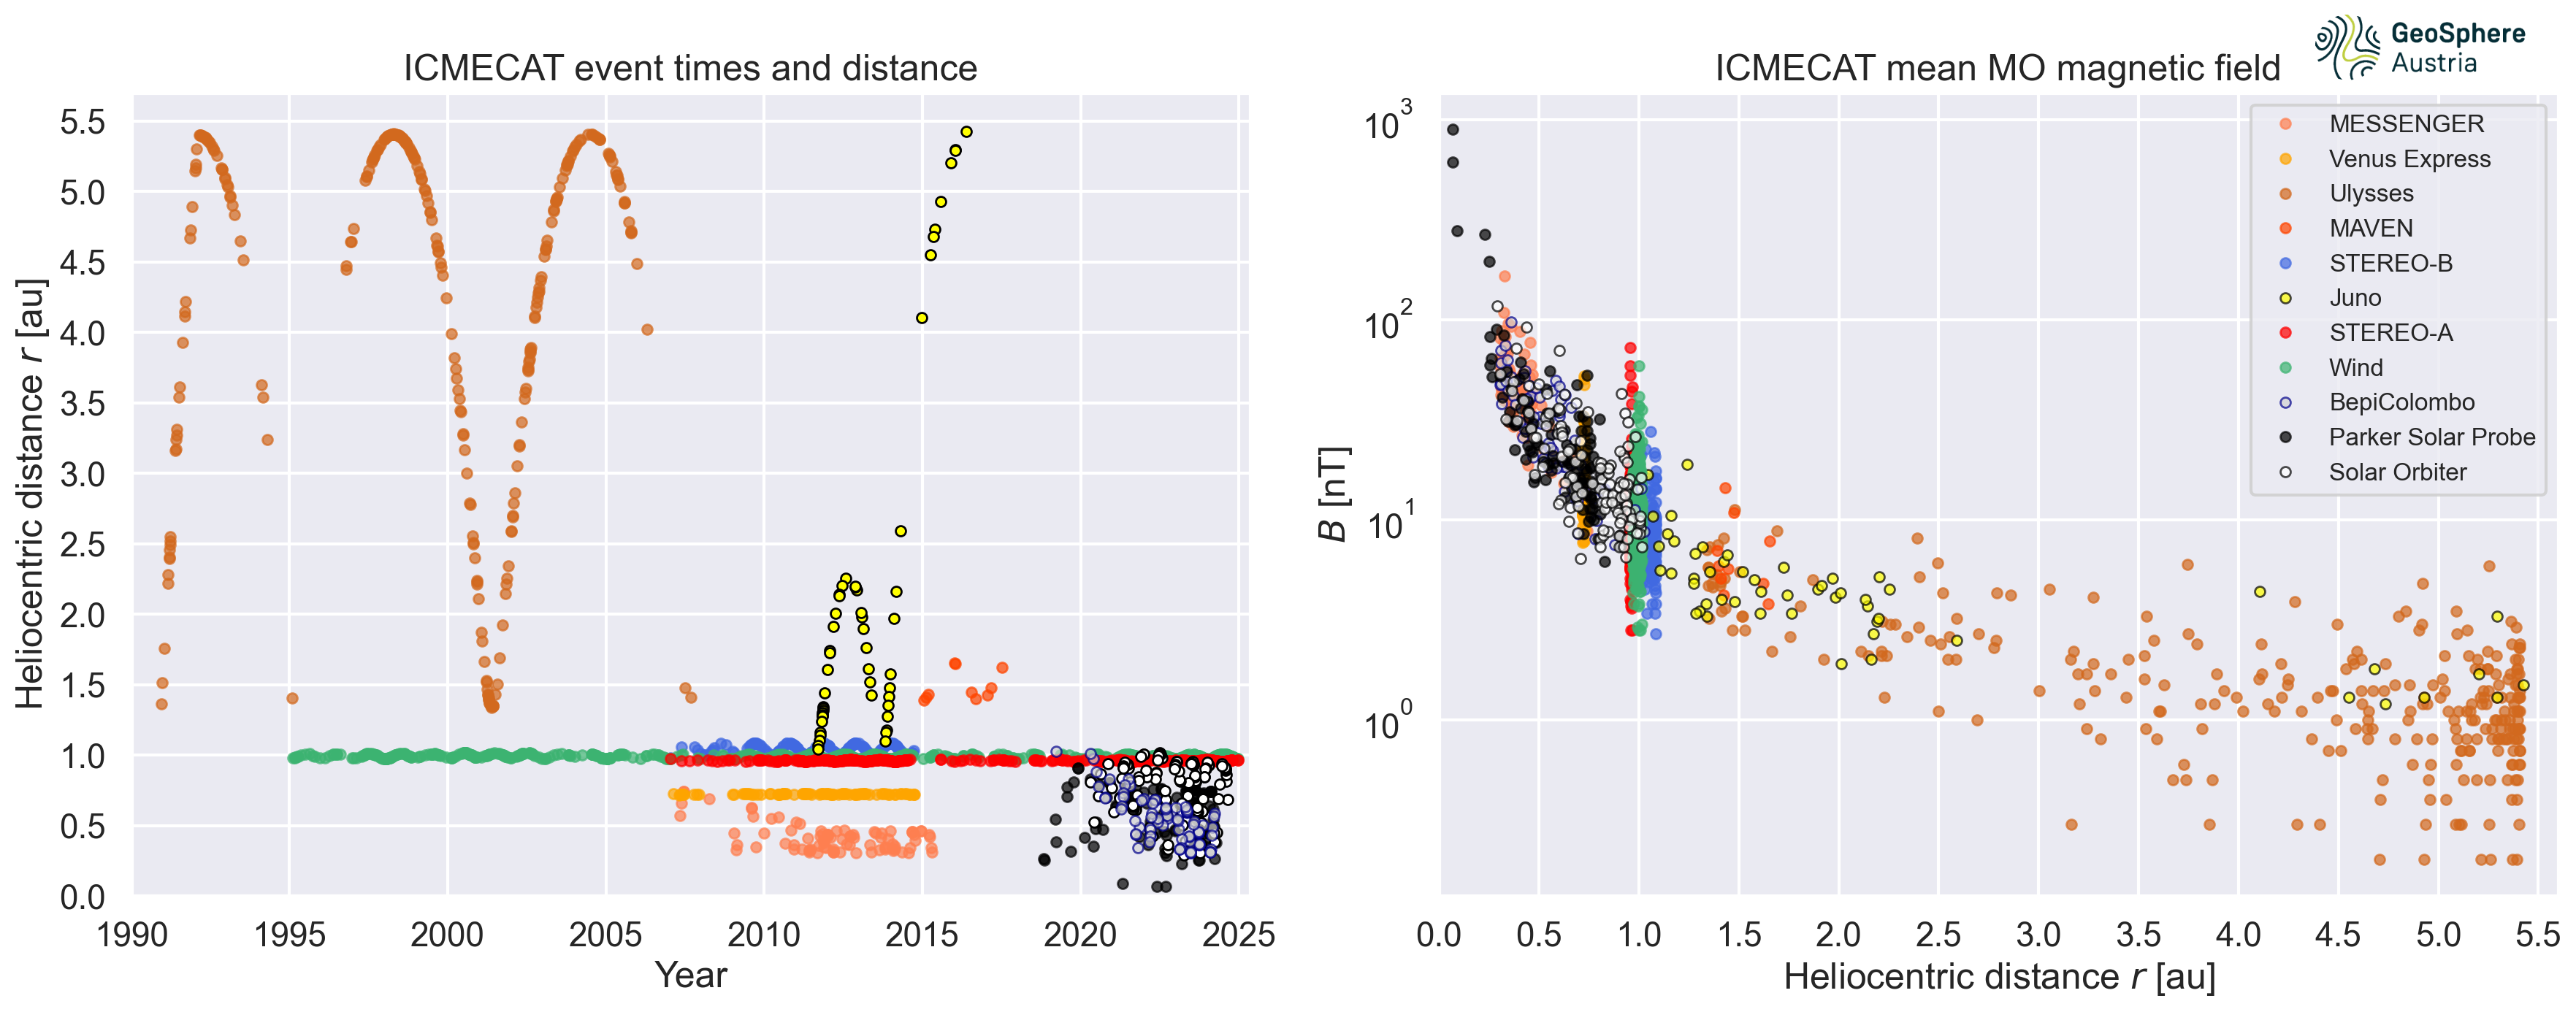

In [13]:
ic=ic_pandas

ic_mo_start_time_num=parse_time(ic.mo_start_time).plot_date

#get indices for each target
imes=np.where(ic.sc_insitu=='MESSENGER')[0]
ivex=np.where(ic.sc_insitu=='VEX')[0]
iwin=np.where(ic.sc_insitu=='Wind')[0]
imav=np.where(ic.sc_insitu=='MAVEN')[0]
ijun=np.where(ic.sc_insitu=='Juno')[0]

ista=np.where(ic.sc_insitu=='STEREO-A')[0]
istb=np.where(ic.sc_insitu=='STEREO-B')[0]
ipsp=np.where(ic.sc_insitu=='PSP')[0]
isol=np.where(ic.sc_insitu=='SolarOrbiter')[0]
ibep=np.where(ic.sc_insitu=='BepiColombo')[0]
iuly=np.where(ic.sc_insitu=='ULYSSES')[0]


sns.set_context("talk")     
sns.set_style('darkgrid')

###############################################################################
fig=plt.figure(3,figsize=(18,7),dpi=200)

#########################################################################
ax1=plt.subplot(121)
plt.title('ICMECAT event times and distance')

#markersize
ms=5
#alpha
al=0.7

ax1.plot_date(ic_mo_start_time_num[iuly],ic.mo_sc_heliodistance[iuly],'o',c='chocolate', alpha=al,ms=ms)
ax1.plot_date(ic_mo_start_time_num[imes],ic.mo_sc_heliodistance[imes],'o',c='coral', alpha=al,ms=ms)
ax1.plot_date(ic_mo_start_time_num[ivex],ic.mo_sc_heliodistance[ivex],'o',c='orange', alpha=al,ms=ms)
ax1.plot_date(ic_mo_start_time_num[istb],ic.mo_sc_heliodistance[istb],'o',c='royalblue', alpha=al,ms=ms)
ax1.plot_date(ic_mo_start_time_num[iwin],ic.mo_sc_heliodistance[iwin],'o',c='mediumseagreen', alpha=al,ms=ms)
ax1.plot_date(ic_mo_start_time_num[imav],ic.mo_sc_heliodistance[imav],'o',c='orangered', alpha=al,ms=ms)
ax1.plot_date(ic_mo_start_time_num[ista],ic.mo_sc_heliodistance[ista],'o',c='red', alpha=al,ms=ms)
ax1.plot_date(ic_mo_start_time_num[ijun],ic.mo_sc_heliodistance[ijun],'o',c='black',markerfacecolor='yellow', alpha=1,ms=ms)

ax1.plot_date(ic_mo_start_time_num[ipsp],ic.mo_sc_heliodistance[ipsp],'o',c='black', alpha=al,ms=ms)
ax1.plot_date(ic_mo_start_time_num[isol],ic.mo_sc_heliodistance[isol],'o',c='black',markerfacecolor='white', alpha=1.0,ms=ms)
ax1.plot_date(ic_mo_start_time_num[ibep],ic.mo_sc_heliodistance[ibep],'o',c='darkblue',markerfacecolor='lightgrey', alpha=al,ms=ms)



ax1.set_ylabel('Heliocentric distance $r$ [au]')
ax1.set_ylim([0,5.7])
ax1.set_yticks(np.arange(0,6,0.5))
#ax1.tick_params(axis="y", labelsize=12)


ax1.set_xlabel('Year')
years = mdates.YearLocator(5)   # every year
ax1.xaxis.set_major_locator(years)
myformat = mdates.DateFormatter('%Y')
ax1.xaxis.set_major_formatter(myformat)

#ax1.tick_params(axis="x", labelsize=12)

#ax1.set_xlim([datetime.datetime(2007,1,1),datetime.datetime.utcnow()+datetime.timedelta(days=50)])

ax1.set_xlim([datetime.datetime(1990,1,1),datetime.datetime.utcnow()+datetime.timedelta(days=50)])



##############################################################################
ax3=plt.subplot(122)
plt.title('ICMECAT mean MO magnetic field')
ax3.set_xlabel('Heliocentric distance $r$ [au]')
ax3.set_ylabel('$B$ [nT]')


ax3.plot(ic.mo_sc_heliodistance[imes],ic.mo_bmean[imes],'o',c='coral', alpha=al,ms=ms,label='MESSENGER')
ax3.plot(ic.mo_sc_heliodistance[ivex],ic.mo_bmean[ivex],'o',c='orange', alpha=al,ms=ms,label='Venus Express')
ax3.plot(ic.mo_sc_heliodistance[iuly],ic.mo_bmean[iuly],'o',c='chocolate', alpha=al,ms=ms, label='Ulysses')
ax3.plot(ic.mo_sc_heliodistance[imav],ic.mo_bmean[imav],'o',c='orangered', alpha=al,ms=ms, label='MAVEN')
ax3.plot(ic.mo_sc_heliodistance[istb],ic.mo_bmean[istb],'o',c='royalblue', alpha=al,ms=ms, label='STEREO-B')
ax3.plot(ic.mo_sc_heliodistance[ijun],ic.mo_bmean[ijun],'o', c='black',markerfacecolor='yellow', alpha=al,ms=ms, label='Juno')

ax3.plot(ic.mo_sc_heliodistance[ista],ic.mo_bmean[ista],'o',c='red', alpha=al,ms=ms, label='STEREO-A')
ax3.plot(ic.mo_sc_heliodistance[iwin],ic.mo_bmean[iwin],'o',c='mediumseagreen', alpha=al,ms=ms,label='Wind')
ax3.plot(ic.mo_sc_heliodistance[ibep],ic.mo_bmean[ibep],'o',c='darkblue',markerfacecolor='lightgrey', alpha=al,ms=ms,label='BepiColombo')
ax3.plot(ic.mo_sc_heliodistance[ipsp],ic.mo_bmean[ipsp],'o',c='black', alpha=al,ms=ms, label='Parker Solar Probe',zorder=3)
ax3.plot(ic.mo_sc_heliodistance[isol],ic.mo_bmean[isol],'o',c='black', markerfacecolor='white',alpha=al,ms=ms, label='Solar Orbiter',zorder=3)


ax3.set_xticks(np.arange(0,6,0.5))
#ax3.tick_params(axis="x", labelsize=12)
ax3.set_xlim([0,5.6])

ax3.set_yscale('log')
#ax3.set_ylim([0,np.max(ic.mo_bmean)+50])
#ax3.set_yticks(np.arange(0,1000,10))
#ax3.set_ylim([0,1000])
#ax3.tick_params(axis="y", labelsize=12)


ax3.legend(loc=1,fontsize=12)#, rows=2)


#ax3.annotate('Quiet Sun',xy=(0.0065,3*1e6),xycoords='data',fontsize=annotfs,ha='left')
#ax3.axvline(1.5,linestyle='--',c='black',alpha=0.5,linewidth=0.7)
#ax3.axvline(1.0,linestyle='--',c='black',alpha=0.5,linewidth=0.7)
#ax3.axvline(0.72,linestyle='--',c='black',alpha=0.5,linewidth=0.7)
#ax3.axvline(0.3,linestyle='--',c='black',alpha=0.5,linewidth=0.7)
#ax3.axvline(5.3,linestyle='--',c='black',alpha=0.5,linewidth=0.7)
#np.max(p_jupiter.r)
#4,95 – 5,458 AE


#Logo
logo = plt.imread('logo/GSA_Basislogo_Positiv_RGB_XXS.png')
newax = fig.add_axes([0.89,0.92,0.08,0.08], anchor='NE', zorder=1)
newax.imshow(logo)
newax.axis('off')

plt.tight_layout()
plt.savefig('icmecat/icmecat_times_distance.png', dpi=150,bbox_inches='tight')

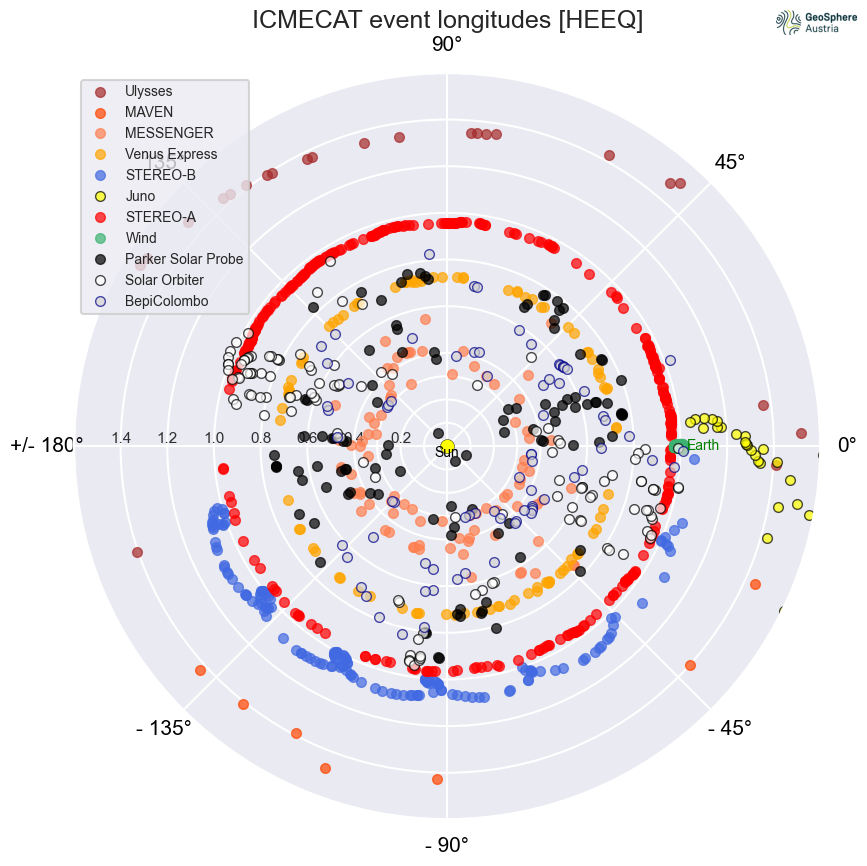

In [14]:
#markersize
ms=7
#alpha
al=0.7

sns.set_context("talk")     
sns.set_style('darkgrid')

###############################################################################
fig=plt.figure(3,figsize=(9,9),dpi=100)

#########################################################################
ax2=plt.subplot(111,projection='polar')

plt.title('ICMECAT event longitudes [HEEQ]')

ax2.plot(np.radians(ic.mo_sc_long_heeq[iuly]),ic.mo_sc_heliodistance[iuly],'o',markersize=ms,c='brown', alpha=al, label='Ulysses')
ax2.plot(np.radians(ic.mo_sc_long_heeq[imav]),ic.mo_sc_heliodistance[imav],'o',markersize=ms,c='orangered', alpha=al, label='MAVEN')

#only inner heliosphere
ax2.plot(np.radians(ic.mo_sc_long_heeq[imes]),ic.mo_sc_heliodistance[imes],'o',markersize=ms,c='coral', alpha=al,label='MESSENGER')
ax2.plot(np.radians(ic.mo_sc_long_heeq[ivex]),ic.mo_sc_heliodistance[ivex],'o',markersize=ms,c='orange', alpha=al,label='Venus Express')
ax2.plot(np.radians(ic.mo_sc_long_heeq[istb]),ic.mo_sc_heliodistance[istb],'o',markersize=ms,c='royalblue', alpha=al,label='STEREO-B')
ax2.plot(np.radians(ic.mo_sc_long_heeq[ijun]),ic.mo_sc_heliodistance[ijun],'o',markersize=ms,c='black',markerfacecolor='yellow',alpha=al,label='Juno')

#ax3.plot(ic.mo_sc_heliodistance[ijun],ic.mo_bmean[ijun],'o', c='black',markerfacecolor='yellow', alpha=al,ms=ms, label='Juno')



ax2.plot(np.radians(ic.mo_sc_long_heeq[ista]),ic.mo_sc_heliodistance[ista],'o',markersize=ms, c='red', alpha=al, label='STEREO-A')
ax2.plot(np.radians(ic.mo_sc_long_heeq[iwin]),ic.mo_sc_heliodistance[iwin],'o',markersize=ms, c='mediumseagreen', alpha=al, label='Wind')
ax2.plot(np.radians(ic.mo_sc_long_heeq[ipsp]),ic.mo_sc_heliodistance[ipsp],'o',markersize=ms, c='black', alpha=al,label='Parker Solar Probe')
ax2.plot(np.radians(ic.mo_sc_long_heeq[isol]),ic.mo_sc_heliodistance[isol],'o',markersize=ms, c='black',markerfacecolor='white', alpha=al, label='Solar Orbiter')
ax2.plot(np.radians(ic.mo_sc_long_heeq[ibep]),ic.mo_sc_heliodistance[ibep],'o',markersize=ms, c='darkblue',markerfacecolor='lightgrey', alpha=al, label='BepiColombo')

plt.legend(loc=2,fontsize=10)


fsize=15
backcolor='black'
frame='HEEQ'
plt.rgrids((0.1,0.2,0.3,0.4,0.6,0.8,1.0,1.2, 1.4,1.6,1.8,2.0),('','0.2','','0.4','0.6','0.8','1.0','1.2','1.4','','',''),angle=180, fontsize=fsize-4,alpha=0.8, ha='center',color=backcolor,zorder=5)
plt.thetagrids(range(0,360,45),(u'0\u00b0',u'45\u00b0',u'90\u00b0',u'135\u00b0',u'+/- 180\u00b0',u'- 135\u00b0',u'- 90\u00b0',u'- 45\u00b0'), fmt='%d',ha='center',fontsize=fsize,color=backcolor, zorder=5, alpha=1.0)

ax2.set_ylim([0,1.6])
ax2.text(0,0,'Sun', color='black', ha='center',fontsize=fsize-5,verticalalignment='top')
ax2.text(0,1.1,'Earth', color='green', ha='center',fontsize=fsize-5,verticalalignment='center')
ax2.scatter(0,0,s=100,c='yellow',alpha=1, edgecolors='black', linewidth=0.3)
    
#logo
logo = plt.imread('logo/GSA_Basislogo_Positiv_RGB_XXS.jpg')
newax = fig.add_axes([0.88,0.88,0.09,0.09], anchor='NE', zorder=1)
newax.imshow(logo)
newax.axis('off')
    
plt.tight_layout()
plt.savefig('icmecat/icmecat_longitudes.png', dpi=150,bbox_inches='tight')

## plotly plots as html

### plotly radial distance and mean MO field

In [15]:
################# 
nrows=1
#init_notebook_mode(connected = True)
#init_notebook_mode(connected = False)

#fig=plt.figure(figsize=(10,6), dpi=150)

fig = make_subplots(rows=nrows, cols=1)



msize=10

fig.add_trace(go.Scatter(x=ic.mo_sc_heliodistance[istb], y=ic.mo_bmean[istb], name='STEREO-B',mode='markers',marker=dict(color='royalblue', size=msize),
        hovertemplate='STEREO-B <br>%{x} AU<br>%{y} nT<br>ID: %{text}', text=ic.icmecat_id[istb] ), row=1, col=1)

fig.add_trace(go.Scatter(x=ic.mo_sc_heliodistance[iuly], y=ic.mo_bmean[iuly], name='Ulysses',mode='markers',marker=dict(color='brown', size=msize),
        hovertemplate='Ulysses <br>%{x} AU<br>%{y} nT<br>ID: %{text}', text=ic.icmecat_id[iuly] ), row=1, col=1)

fig.add_trace(go.Scatter(x=ic.mo_sc_heliodistance[imav], y=ic.mo_bmean[imav], name='MAVEN',mode='markers',marker=dict(color='orangered', size=msize),
        hovertemplate='MAVEN<br>%{x} AU<br>%{y} nT<br>ID: %{text}', text=ic.icmecat_id[imav] ), row=1, col=1)

fig.add_trace(go.Scatter(x=ic.mo_sc_heliodistance[imes], y=ic.mo_bmean[imes], name='MESSENGER',mode='markers',marker=dict(color='coral', size=msize),
        hovertemplate='MESSENGER<br>%{x} AU<br>%{y} nT<br>ID: %{text}', text=ic.icmecat_id[imes] ), row=1, col=1)

fig.add_trace(go.Scatter(x=ic.mo_sc_heliodistance[ivex], y=ic.mo_bmean[ivex], name='Venus Express',mode='markers',marker=dict(color='orange', size=msize),
        hovertemplate='Venus Express<br>%{x} AU<br>%{y} nT<br>ID: %{text}', text=ic.icmecat_id[ivex] ), row=1, col=1)

fig.add_trace(go.Scatter(x=ic.mo_sc_heliodistance[ipsp], y=ic.mo_bmean[ipsp], name='PSP',mode='markers',marker=dict(color='black', size=msize),
        hovertemplate='Parker Solar Probe<br>%{x} AU<br>%{y} nT<br>ID: %{text}', text=ic.icmecat_id[ipsp] ), row=1, col=1)
              
fig.add_trace(go.Scatter(x=ic.mo_sc_heliodistance[isol], y=ic.mo_bmean[isol], name='Solar Orbiter',mode='markers',marker=dict(color='white', size=msize,  
    line=dict(color='black', width=1)),hovertemplate='Solar Orbiter<br>%{x} AU<br>%{y} nT<br>ID: %{text}', text=ic.icmecat_id[isol]   ), row=1, col=1)

fig.add_trace(go.Scatter(x=ic.mo_sc_heliodistance[iwin], y=ic.mo_bmean[iwin], name='Wind',mode='markers',marker=dict(color='mediumseagreen', size=msize),
        hovertemplate='Wind<br>%{x} AU<br>%{y} nT<br>ID: %{text}', text=ic.icmecat_id[iwin] ), row=1, col=1)

fig.add_trace(go.Scatter(x=ic.mo_sc_heliodistance[ista], y=ic.mo_bmean[ista], name='STEREO-A',mode='markers',marker=dict(color='red', size=msize),
        hovertemplate='STEREO-A<br>%{x} AU<br>%{y} nT<br>ID: %{text}', text=ic.icmecat_id[ista] ), row=1, col=1)


fig.add_trace(go.Scatter(x=ic.mo_sc_heliodistance[ibep], y=ic.mo_bmean[ibep], name='BepiColombo',mode='markers',marker=dict(color='lightgrey', size=msize,  
    line=dict(color='darkblue', width=1)),hovertemplate='BepiColombo<br>%{x} AU<br>%{y} nT<br>ID: %{text}', text=ic.icmecat_id[ibep]   ), row=1, col=1)

fig.add_trace(go.Scatter(x=ic.mo_sc_heliodistance[ijun], y=ic.mo_bmean[ijun], name='Juno',mode='markers',marker=dict(color='yellow', size=msize,  
    line=dict(color='black', width=1)),hovertemplate='Juno<br>%{x} AU<br>%{y} nT<br>ID: %{text}', text=ic.icmecat_id[ijun]   ), row=1, col=1)

fig.update_yaxes(title_text="B [nT]", row=1, col=1)
fig.update_xaxes(title_text="R [AU]", row=1, col=1)

fig.update_layout(title='ICMECAT magnetic obstacle mean B total field')


#fig.update_layout(
#    hoverlabel=dict(
#        bgcolor="white",
#        font_size=16,
#        font_family="Arial"
#    )
#)


fig.write_html(f'icmecat/icmecat_distance.html')


#https://plotly.com/python/hover-text-and-formatting/

### plotly event position in 3D

In [16]:
# Create polar plot
fig = go.Figure()

msize=5

#in AU, make sure conversion is correct so latitude is 0 to 90 
[x,y,z]=hd.sphere2cart(ic.mo_sc_heliodistance.values, -np.deg2rad(ic.mo_sc_lat_heeq.values-90), np.deg2rad(ic.mo_sc_long_heeq.values))
    
    
#add orbit    
#fig.add_trace(go.Scatter3d(x=pos[0].x, y=pos[0].y, z=pos[0].z, name='PSP',mode='lines',line=dict(color='black')))
#fig.add_trace(go.Scatter3d(x=pos[1].x, y=pos[1].y, z=pos[1].z, name='Solar Orbiter',mode='lines',line=dict(color='green')))
#fig.add_trace(go.Scatter3d(x=pos[2].x, y=pos[2].y, z=pos[2].z, name='STEREO-A',mode='lines',line=dict(color='red')))

    

fig.add_trace(go.Scatter3d(x=x[ipsp], y=y[ipsp], z=z[ipsp], name='PSP',mode='markers',marker=dict(color='black', size=msize),
        hovertemplate='Parker Solar Probe<br>ID: %{text}',text=ic.icmecat_id[ipsp] ))

fig.add_trace(go.Scatter3d(x=x[isol], y=y[isol], z=z[isol], name='Solar Orbiter',mode='markers',marker=dict(color='white', size=msize,  
    line=dict(color='black', width=1)),
        hovertemplate='Solar Orbiter<br>ID: %{text}', text=ic.icmecat_id[isol] ))

fig.add_trace(go.Scatter3d(x=x[iwin], y=y[iwin], z=z[iwin], name='Wind',mode='markers',marker=dict(color='mediumseagreen', size=msize),
        hovertemplate='Wind<br>ID: %{text}', text=ic.icmecat_id[iwin] ))

fig.add_trace(go.Scatter3d(x=x[ista], y=y[ista], z=z[ista], name='STEREO-A',mode='markers',marker=dict(color='red', size=msize),
        hovertemplate='STEREO-A<br>ID: %{text}', text=ic.icmecat_id[ista] ))

fig.add_trace(go.Scatter3d(x=x[ijun], y=y[ijun], z=z[ijun], name='Juno',mode='markers',marker=dict(color='yellow', size=msize,  
    line=dict(color='black', width=1)),
        hovertemplate='Juno<br>ID: %{text}', text=ic.icmecat_id[ijun] ))

fig.add_trace(go.Scatter3d(x=x[ibep], y=y[ibep], z=z[ibep], name='BepiColombo',mode='markers',marker=dict(color='lightgrey', size=msize,  
    line=dict(color='darkblue', width=1)),
        hovertemplate='BepiColombo<br>ID: %{text}', text=ic.icmecat_id[ibep] ))

fig.add_trace(go.Scatter3d(x=x[istb], y=y[istb], z=z[istb], name='STEREO-B',mode='markers',marker=dict(color='royalblue', size=msize),
        hovertemplate='STEREO-B<br>ID: %{text}', text=ic.icmecat_id[istb] ))

fig.add_trace(go.Scatter3d(x=x[iuly], y=y[iuly], z=z[iuly], name='Ulysses',mode='markers',marker=dict(color='brown', size=msize),
        hovertemplate='Ulysses<br>ID: %{text}', text=ic.icmecat_id[iuly] ))

fig.add_trace(go.Scatter3d(x=x[imav], y=y[imav], z=z[imav], name='MAVEN',mode='markers',marker=dict(color='orangered', size=msize),
        hovertemplate='MAVEN<br>ID: %{text}', text=ic.icmecat_id[imav] ))

fig.add_trace(go.Scatter3d(x=x[imes], y=y[imes], z=z[imes], name='MESSENGER',mode='markers',marker=dict(color='coral', size=msize),
        hovertemplate='MESSENGER<br>ID: %{text}', text=ic.icmecat_id[imes] ))

fig.add_trace(go.Scatter3d(x=x[ivex], y=y[ivex], z=z[ivex], name='Venus Express',mode='markers',marker=dict(color='orange', size=msize),
        hovertemplate='Venus Express<br>ID: %{text}', text=ic.icmecat_id[ivex] ))








############# add Sun
# Create data for a sphere
theta = np.linspace(0, np.pi, 100)
phi = np.linspace(0, 2*np.pi, 100)
theta, phi = np.meshgrid(theta, phi)
r = (700*1e3)/(149.5*1e6)*10  # 10 solar radii

# Convert spherical coordinates to Cartesian coordinates
[x,y,z]=hd.sphere2cart(r, theta,phi)
# Create 3D surface plot

fig.add_trace(go.Surface(x=x, y=y,z=z, colorscale='hot', showscale=False, name='10 R_Sun'))

################### add circle at 1 AU

num_points = 100
# Create theta values (angles) for the circle
theta_values = np.linspace(0, 2*np.pi, num_points)
r = 1  # radius of the circle
x_values = r * np.cos(theta_values)
y_values = r * np.sin(theta_values)

fig.add_trace(go.Scatter3d(
    x=x_values,
    y=y_values,
    z=np.zeros(num_points),  # Set z-values to zero for 2D appearance
    mode='lines', name='1 AU',
    line=dict(color='black', width=1)
))


fig.add_trace(go.Scatter3d(
    x=x_values*0.7,
    y=y_values*0.7,
    z=np.zeros(num_points),  # Set z-values to zero for 2D appearance
    mode='lines', name='0.7 AU',
    line=dict(color='black', width=1)
))


fig.add_trace(go.Scatter3d(
    x=x_values*0.5,
    y=y_values*0.5,
    z=np.zeros(num_points),  # Set z-values to zero for 2D appearance
    mode='lines', name='0.5 AU',
    line=dict(color='black', width=1)
))

fig.add_trace(go.Scatter3d(
    x=x_values*0.3,
    y=y_values*0.3,
    z=np.zeros(num_points),  # Set z-values to zero for 2D appearance
    mode='lines', name='0.3 AU',
    line=dict(color='black', width=1)
))

fig.add_trace(go.Scatter3d(
    x=x_values*0.1,
    y=y_values*0.1,
    z=np.zeros(num_points),  # Set z-values to zero for 2D appearance
    mode='lines', name='0.1 AU',
    line=dict(color='black', width=1)
))


#add Sun-Earth line for HEEQ latitude 0
fig.add_trace(go.Scatter3d(
    x=np.linspace(0,1,num_points),
    y=np.zeros(num_points),
    z=np.zeros(num_points), 
    mode='lines', name='Sun-Earth line',
    line=dict(color='red', width=1)
))



zoom=0.2

fig.update_layout(
    title='ICMECAT event positions in 3D / HEEQ coordinates',
    scene=dict( aspectmode='data',
        xaxis=dict(title='X '),
        yaxis=dict(title='Y'),
        zaxis=dict(title='Z'),
        camera=dict(
            eye=dict(x=0, y=-zoom, z=zoom),  # Set the position of the camera
            center=dict(x=0, y=0, z=0),      # Set the point the camera is looking at
            up=dict(x=0, y=0, z=1),          # Set the up vector of the camera
           
    ))
)

fig.write_html(f'icmecat/icmecat_position_3D.html')

#save as image
#pio.write_image(fig, 'icmecat/icmecat_position_3D.pdf',scale=1, width=3000, height=1500)
pio.write_image(fig, 'icmecat/icmecat_position_3D.png',scale=2, width=1500, height=850)


### plotly radial distance and longitude

In [17]:
# Sample data


msize=10
# Create polar plot
fig = go.Figure()

#fig.add_trace(go.Scatterpolar(r=r_values, theta=theta_values, mode='lines+markers',line=dict(color='blue'), marker=dict(color='blue', size=10)))

fig.add_trace(go.Scatterpolar(r=ic.mo_sc_heliodistance[ipsp], theta=ic.mo_sc_long_heeq[ipsp], name='PSP',mode='markers',marker=dict(color='black', size=msize),
        hovertemplate='Parker Solar Probe<br>%{r} AU<br>%{theta}<br>ID: %{text}', text=ic.icmecat_id[ipsp] ))


fig.add_trace(go.Scatterpolar(r=ic.mo_sc_heliodistance[istb], theta=ic.mo_sc_long_heeq[istb], name='STEREO-B',mode='markers',marker=dict(color='royalblue', size=msize),
        hovertemplate='STEREO-B <br>%{r} AU<br>%{theta}<br>ID: %{text}', text=ic.icmecat_id[istb] ))


fig.add_trace(go.Scatterpolar(r=ic.mo_sc_heliodistance[iuly], theta=ic.mo_sc_long_heeq[iuly], name='Ulysses',mode='markers',marker=dict(color='brown', size=msize),
        hovertemplate='Ulysses <br>%{r} AU<br>%{theta}<br>ID: %{text}', text=ic.icmecat_id[iuly] ))

fig.add_trace(go.Scatterpolar(r=ic.mo_sc_heliodistance[imav], theta=ic.mo_sc_long_heeq[imav], name='MAVEN',mode='markers',marker=dict(color='orangered', size=msize),
        hovertemplate='MAVEN<br>%{r} AU<br>%{theta}<br>ID: %{text}', text=ic.icmecat_id[imav] ))

fig.add_trace(go.Scatterpolar(r=ic.mo_sc_heliodistance[imes], theta=ic.mo_sc_long_heeq[imes], name='MESSENGER',mode='markers',marker=dict(color='coral', size=msize),
        hovertemplate='MESSENGER<br>%{r} AU<br>%{theta}<br>ID: %{text}', text=ic.icmecat_id[imes] ))

fig.add_trace(go.Scatterpolar(r=ic.mo_sc_heliodistance[ivex], theta=ic.mo_sc_long_heeq[ivex], name='Venus Express',mode='markers',marker=dict(color='orange', size=msize),
        hovertemplate='Venus Express<br>%{r} AU<br>%{theta}<br>ID: %{text}', text=ic.icmecat_id[ivex] ))
              
fig.add_trace(go.Scatterpolar(r=ic.mo_sc_heliodistance[isol], theta=ic.mo_sc_long_heeq[isol], name='Solar Orbiter',mode='markers',marker=dict(color='white', size=msize,  
    line=dict(color='black', width=1)),hovertemplate='Solar Orbiter<br>%{r} AU<br>%{theta}<br>ID: %{text}', text=ic.icmecat_id[isol]   ))

fig.add_trace(go.Scatterpolar(r=ic.mo_sc_heliodistance[iwin], theta=ic.mo_sc_long_heeq[iwin], name='Wind',mode='markers',marker=dict(color='mediumseagreen', size=msize),
        hovertemplate='Wind<br>%{r} AU<br>%{theta}<br>ID: %{text}', text=ic.icmecat_id[iwin] ))

fig.add_trace(go.Scatterpolar(r=ic.mo_sc_heliodistance[ista], theta=ic.mo_sc_long_heeq[ista], name='STEREO-A',mode='markers',marker=dict(color='red', size=msize),
        hovertemplate='STEREO-A<br>%{r} AU<br>%{theta}<br>ID: %{text}', text=ic.icmecat_id[ista] ))


fig.add_trace(go.Scatterpolar(r=ic.mo_sc_heliodistance[ibep], theta=ic.mo_sc_long_heeq[ibep], name='BepiColombo',mode='markers',marker=dict(color='lightgrey', size=msize,  
    line=dict(color='darkblue', width=1)),hovertemplate='BepiColombo<br>%{r} AU<br>%{theta}<br>ID: %{text}', text=ic.icmecat_id[ibep]   ))

fig.add_trace(go.Scatterpolar(r=ic.mo_sc_heliodistance[ijun], theta=ic.mo_sc_long_heeq[ijun], name='Juno',mode='markers',marker=dict(color='yellow', size=msize,  
    line=dict(color='black', width=1)),hovertemplate='Juno<br>%{r} AU<br>%{theta}<br>ID: %{text}', text=ic.icmecat_id[ijun]   ))

              
# Update layout if necessary
fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 1.7]  # Set the range for the radial axis
        ),
        angularaxis=dict(
            tickmode='array',
            tickvals=[0, 45, 90, 135, 180, 225, 270, 315],  # Specify tick values for angular axis
            ticktext=['0°', '45°', '90°', '135°', '180°', '225°', '270°', '315°'],  # Specify tick labels for angular axis
        )
    )
)


fig.update_layout(title='ICMECAT radial distance and HEEQ longitude of ICME events')

fig.write_html(f'icmecat/icmecat_longitudes.html')

### 3D plotly for PSP, SolO, Bepi

In [18]:
#convert times to datetime

psptime_raw=mdates.num2date(pos[0].time)
psptime=np.zeros(len(psptime_raw),dtype='object')

for i in np.arange(len(psptime_raw)):
    psptime[i]=datetime.datetime(psptime_raw[i].year,psptime_raw[i].month,psptime_raw[i].day,psptime_raw[i].hour,psptime_raw[i].minute)

solotime_raw=mdates.num2date(pos[1].time)
solotime=np.zeros(len(solotime_raw),dtype='object')

for i in np.arange(len(solotime_raw)):
    solotime[i]=datetime.datetime(solotime_raw[i].year,solotime_raw[i].month,solotime_raw[i].day,solotime_raw[i].hour,solotime_raw[i].minute)
        
#interpolate position file to daily values for faster computation and lower file size of the html

#SolO
start_time = solotime[0]
end_time = solotime[-1]
solo_daily = pd.date_range(start=start_time, end=end_time, freq='D').date 
solo_daily_num = mdates.date2num(solo_daily)

solox=np.interp(solo_daily_num, pos[1].time.astype(float), pos[1].x)
soloy=np.interp(solo_daily_num, pos[1].time.astype(float), pos[1].y)
soloz=np.interp(solo_daily_num, pos[1].time.astype(float), pos[1].z)


#PSP  
start_time = psptime[0]
end_time = psptime[-1]
psp_daily = pd.date_range(start=start_time, end=end_time, freq='H').date  ##****** need to add this with .time for hourly data
psp_daily_num = mdates.date2num(psp_daily)

pspx=np.interp(psp_daily_num, pos[0].time.astype(float), pos[0].x)
pspy=np.interp(psp_daily_num, pos[0].time.astype(float), pos[0].y)
pspz=np.interp(psp_daily_num, pos[0].time.astype(float), pos[0].z)
    

In [19]:
# Create polar plot
fig = go.Figure()

mfac=10


#in AU, make sure conversion is correct so latitude is 0 to 90 
[x,y,z]=hd.sphere2cart(ic.mo_sc_heliodistance.values, -np.deg2rad(ic.mo_sc_lat_heeq.values-90), np.deg2rad(ic.mo_sc_long_heeq.values))
   
    
#add orbit    

### PSP
#fig.add_trace(go.Scatter3d(x=pspx, y=pspy, z=pspz, name='PSP',mode='lines',line=dict(color='black'),
#        hovertemplate='PSP orbit<br>time: %{text}',text=psp_daily))

#fig.add_trace(go.Scatter3d(x=pos[0].x, y=pos[0].y, z=pos[0].z, name='PSP',mode='lines',line=dict(color='black'),
#        hovertemplate='PSP orbit<br>time: %{text}',text=psptime))


# SOLO
fig.add_trace(go.Scatter3d(x=solox, y=soloy, z=soloz, name='Solar Orbiter',mode='lines',line=dict(color='green'), 
        hovertemplate='Solar Orbiter orbit<br>time: %{text}',text=solo_daily))
             
#fig.add_trace(go.Scatter3d(x=pos[4].x, y=pos[4].y, z=pos[4].z, name='BepiColombo',mode='lines',line=dict(color='blue')))
#fig.add_trace(go.Scatter3d(x=pos[2].x, y=pos[2].y, z=pos[2].z, name='STEREO-A',mode='lines',line=dict(color='red')))

   

fig.add_trace( go.Scatter3d(x=x[ipsp], y=y[ipsp], z=z[ipsp], name='PSP',mode='markers',marker=dict(color='black', size=np.log10(ic.mo_bmean[ipsp])*mfac),
               hovertemplate='Parker Solar Probe<br>ID: %{text}',text=ic.icmecat_id[ipsp]) ) 

fig.add_trace(go.Scatter3d(x=x[isol], y=y[isol], z=z[isol], name='Solar Orbiter',mode='markers',marker=dict(color='white', size=np.log10(ic.mo_bmean[isol])*mfac,  
    line=dict(color='black', width=1)), hovertemplate='Solar Orbiter<br>ID: %{text}', text=ic.icmecat_id[isol] ))

fig.add_trace(go.Scatter3d(x=x[ibep], y=y[ibep], z=z[ibep], name='BepiColombo',mode='markers',marker=dict(color='lightgrey', size=np.log10(ic.mo_bmean[ibep])*mfac,  
    line=dict(color='darkblue', width=1)), hovertemplate='BepiColombo<br>ID: %{text}', text=ic.icmecat_id[ibep] ))

fig.add_trace(go.Scatter3d(x=x[iwin], y=y[iwin], z=z[iwin], name='Wind',mode='markers',marker=dict(color='mediumseagreen', size=np.log10(ic.mo_bmean[iwin])*mfac),
        hovertemplate='Wind<br>ID: %{text}', text=ic.icmecat_id[iwin] ))

fig.add_trace(go.Scatter3d(x=x[ista], y=y[ista], z=z[ista], name='STEREO-A',mode='markers',marker=dict(color='red', size=np.log10(ic.mo_bmean[ista])*mfac),
        hovertemplate='STEREO-A<br>ID: %{text}', text=ic.icmecat_id[ista] ))


############# add Sun
# Create data for a sphere
theta = np.linspace(0, np.pi, 100)
phi = np.linspace(0, 2*np.pi, 100)
theta, phi = np.meshgrid(theta, phi)
r = (700*1e3)/(149.5*1e6)*5  # 10 solar radii

# Convert spherical coordinates to Cartesian coordinates
[x,y,z]=hd.sphere2cart(r, theta,phi)
# Create 3D surface plot

fig.add_trace(go.Surface(x=x, y=y,z=z, colorscale='hot', showscale=False, name='5 R_Sun'))

################### add circle at 1 AU

num_points = 100
# Create theta values (angles) for the circle
theta_values = np.linspace(0, 2*np.pi, num_points)
r = 1  # radius of the circle
x_values = r * np.cos(theta_values)
y_values = r * np.sin(theta_values)

fig.add_trace(go.Scatter3d(
    x=x_values,
    y=y_values,
    z=np.zeros(num_points),  # Set z-values to zero for 2D appearance
    mode='lines', name='1 AU',
    line=dict(color='black', width=1)
))


fig.add_trace(go.Scatter3d(
    x=x_values*0.7,
    y=y_values*0.7,
    z=np.zeros(num_points),  # Set z-values to zero for 2D appearance
    mode='lines', name='0.7 AU',
    line=dict(color='black', width=1)
))


fig.add_trace(go.Scatter3d(
    x=x_values*0.5,
    y=y_values*0.5,
    z=np.zeros(num_points),  # Set z-values to zero for 2D appearance
    mode='lines', name='0.5 AU',
    line=dict(color='black', width=1)
))

fig.add_trace(go.Scatter3d(
    x=x_values*0.3,
    y=y_values*0.3,
    z=np.zeros(num_points),  # Set z-values to zero for 2D appearance
    mode='lines', name='0.3 AU',
    line=dict(color='black', width=1)
))

fig.add_trace(go.Scatter3d(
    x=x_values*0.1,
    y=y_values*0.1,
    z=np.zeros(num_points),  # Set z-values to zero for 2D appearance
    mode='lines', name='0.1 AU',
    line=dict(color='black', width=1)
))


#add Sun-Earth line for HEEQ latitude 0
fig.add_trace(go.Scatter3d(
    x=np.linspace(0,1,num_points),
    y=np.zeros(num_points),
    z=np.zeros(num_points), 
    mode='lines', name='Sun-Earth line',
    line=dict(color='red', width=1)
))


#add 10° to SE line
fig.add_trace(go.Scatter3d(
    x=np.linspace(0,1,num_points)*np.cos(np.deg2rad(10)),
    y=np.linspace(0,1,num_points)*np.sin(np.deg2rad(10)),
    z=np.zeros(num_points), 
    mode='lines', name='10°',
    line=dict(color='red', width=1)
))



#add 20° to SE line
fig.add_trace(go.Scatter3d(
    x=np.linspace(0,1,num_points)*np.cos(np.deg2rad(20)),
    y=np.linspace(0,1,num_points)*np.sin(np.deg2rad(20)),
    z=np.zeros(num_points), 
    mode='lines', name='20°',
    line=dict(color='red', width=1)
))


#add 30° to SE line
fig.add_trace(go.Scatter3d(
    x=np.linspace(0,1,num_points)*np.cos(np.deg2rad(30)),
    y=np.linspace(0,1,num_points)*np.sin(np.deg2rad(30)),
    z=np.zeros(num_points), 
    mode='lines', name='30°',
    line=dict(color='red', width=1)
))

#add 10° to SE line
fig.add_trace(go.Scatter3d(
    x=np.linspace(0,1,num_points)*np.cos(np.deg2rad(-10)),
    y=np.linspace(0,1,num_points)*np.sin(np.deg2rad(-10)),
    z=np.zeros(num_points), 
    mode='lines', name='-10°',
    line=dict(color='red', width=1)
))


#add 20° to SE line
fig.add_trace(go.Scatter3d(
    x=np.linspace(0,1,num_points)*np.cos(np.deg2rad(-20)),
    y=np.linspace(0,1,num_points)*np.sin(np.deg2rad(-20)),
    z=np.zeros(num_points), 
    mode='lines', name='-20°',
    line=dict(color='red', width=1)
))



#add 30° to SE line
fig.add_trace(go.Scatter3d(
    x=np.linspace(0,1,num_points)*np.cos(np.deg2rad(-30)),
    y=np.linspace(0,1,num_points)*np.sin(np.deg2rad(-30)),
    z=np.zeros(num_points), 
    mode='lines', name='-30°',
    line=dict(color='red', width=1)
))



#add 60° to SE line
fig.add_trace(go.Scatter3d(
    x=np.linspace(0,1,num_points)*np.cos(np.deg2rad(-60)),
    y=np.linspace(0,1,num_points)*np.sin(np.deg2rad(-60)),
    z=np.zeros(num_points), 
    mode='lines', name='L5',
    line=dict(color='blue', width=1)
))



zoom=1.2

fig.update_layout(
    title='ICMECAT event positions in 3D, Solar Orbiter trajectory (HEEQ coordinates)',
    scene=dict( aspectmode='data',
        xaxis=dict(title='X '),
        yaxis=dict(title='Y'),
        zaxis=dict(title='Z'),
        camera=dict(
            eye=dict(x=zoom, y=0, z=zoom),  # Set the position of the camera
            center=dict(x=0, y=0, z=0),      # Set the point the camera is looking at
            up=dict(x=0, y=0, z=1),          # Set the up vector of the camera
           
    ))
)


#import plotly
#plotly.offline.plot(fig, include_plotlyjs=False, output_type='div')

#fig.write_html(f'icmecat/icmecat_orbit_3D_psp_solo.html')
#fig.write_html(f'icmecat/icmecat_orbit_3D_solo_psp.html')
#pio.write_image(fig, 'icmecat/icmecat_orbit_3D_solo_psp.png',scale=1, width=1500, height=850)

fig.write_html(f'icmecat/icmecat_orbit_3D_solo.html')
pio.write_image(fig, 'icmecat/icmecat_orbit_3D_solo.png',scale=1, width=1500, height=1200)


## Parameter distribution plots near 1 AU

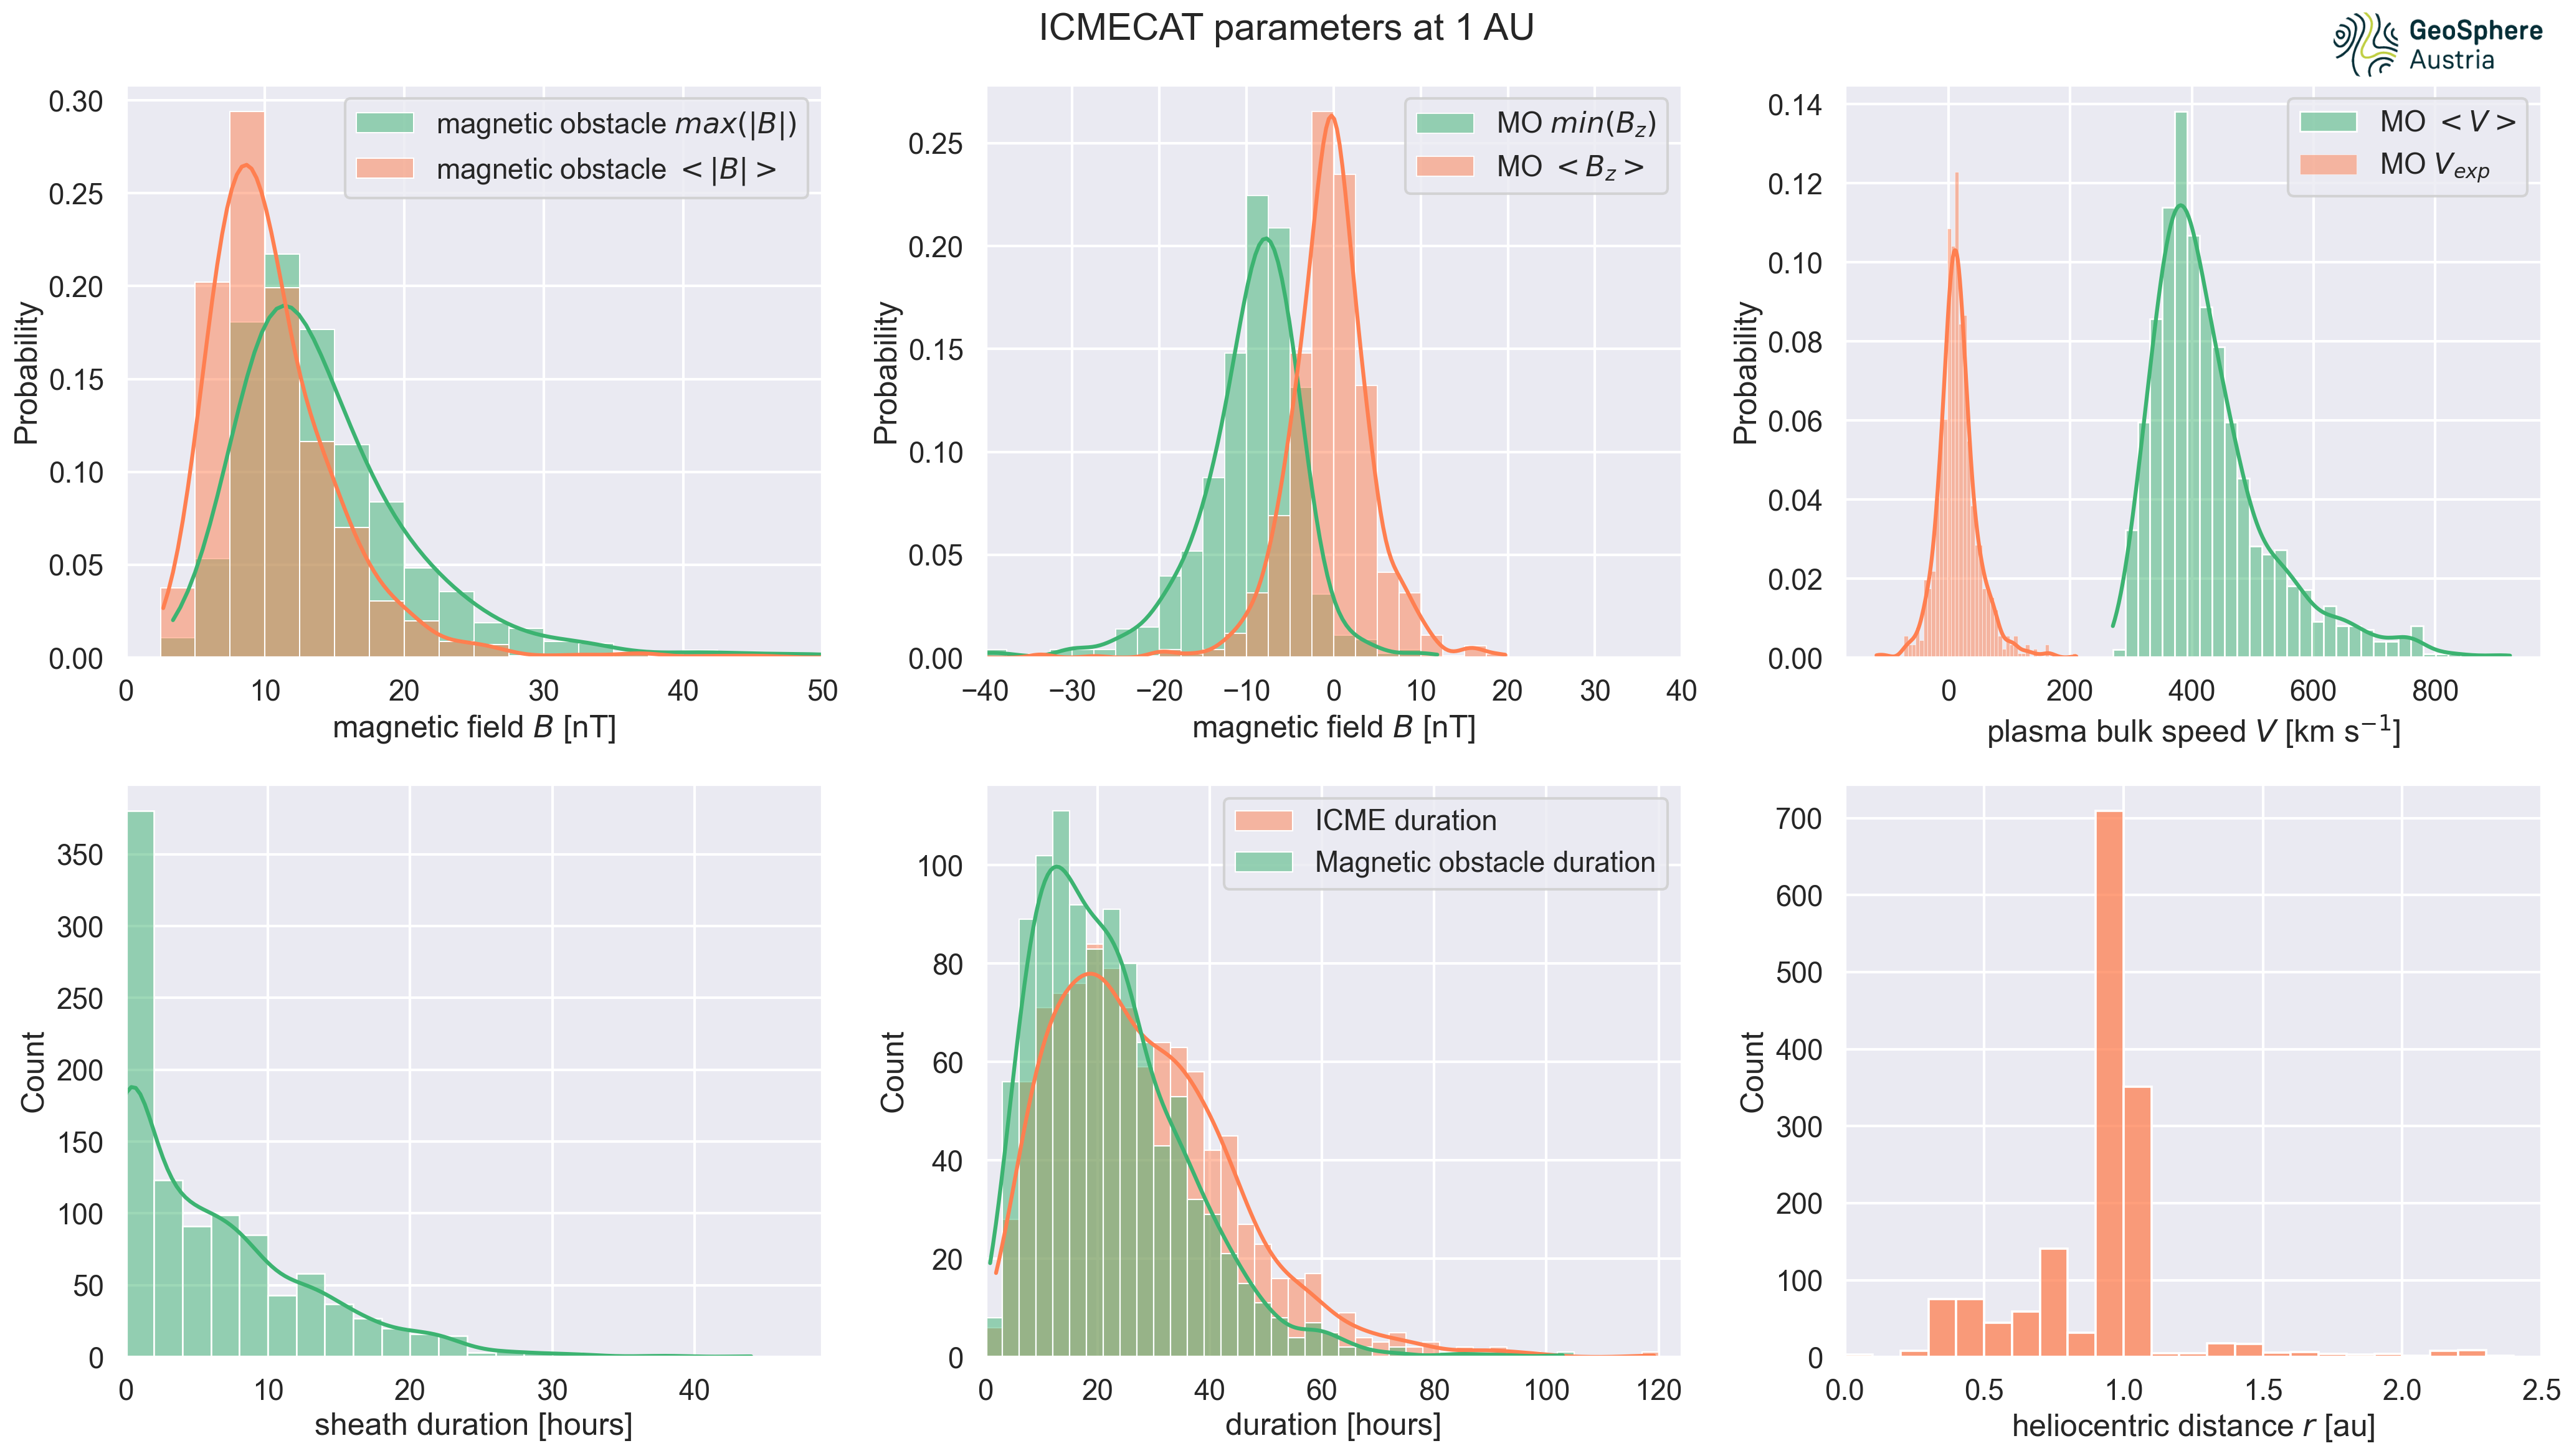

In [20]:
#make distribution plots
fig=plt.figure(10,figsize=(21,12),dpi=200)


i1au=np.hstack([iwin,ista,istb])


ax2=plt.subplot(231)
sns.histplot(ic.mo_bmax[i1au], label='magnetic obstacle $max(|B|)$',color='mediumseagreen',kde=True, bins=np.arange(0,100,2.5), stat='probability')
sns.histplot(ic.mo_bmean[i1au], label='magnetic obstacle $<|B|>$',color='coral',alpha=0.5,kde=True, bins=np.arange(0,100,2.5),stat='probability')
plt.legend(loc=1)
ax2.set_xlabel('magnetic field $B$ [nT]')
ax2.set_xlim(0,50)


ax3=plt.subplot(232)
sns.histplot(ic.mo_bzmin[i1au],label='MO $min(B_z)$',color='mediumseagreen',kde=True, bins=np.arange(-50,50,2.5),stat='probability')
sns.histplot(ic.mo_bzmean[i1au],label='MO $<B_z>$',color='coral',alpha=0.5,kde=True, bins=np.arange(-50,50,2.5),stat='probability')
plt.legend(loc=1)
ax3.set_xlabel('magnetic field $B$ [nT]')
plt.xlim(-40,40)


ax4=plt.subplot(233)
sns.histplot(ic.mo_speed_mean[i1au],label='MO $<V>$',color='mediumseagreen',kde=True,stat='probability')
sns.histplot(ic.mo_expansion_speed[i1au],label='MO $V_{exp}$',color='coral',alpha=0.5,kde=True,stat='probability')
plt.legend(loc=1)
ax4.set_xlabel('plasma bulk speed $V$ [km s$^{-1}$]')


ax5=plt.subplot(236)
sns.histplot(ic.mo_sc_heliodistance,color='coral',bins=np.arange(0,2.5,0.1))
ax5.set_xlim(0,2.5)
ax5.set_xlabel('heliocentric distance $r$ [au]')


ax6=plt.subplot(235)
sns.histplot(ic.icme_duration[i1au],color='coral',alpha=0.5,bins=np.arange(0,np.max(ic.icme_duration[i1au])+5,3),kde=True,stat='count',label='ICME duration')
sns.histplot(ic.mo_duration[i1au],color='mediumseagreen',bins=np.arange(0,np.max(ic.mo_duration[i1au])+5,3),kde=True, stat='count',label='Magnetic obstacle duration')
ax6.set_xlabel('duration [hours]')
ax6.set_xlim(0,np.max(ic.icme_duration[i1au])+5)
plt.legend(loc=1)

ax7=plt.subplot(234)
#sns.histplot(ic.mo_duration,color='coral',bins=np.arange(0,np.max(ic.mo_duration)+5,3),kde=True, stat='count')
#sheath duration
sns.histplot(ic.icme_duration[i1au]-ic.mo_duration[i1au],color='mediumseagreen',bins=np.arange(0,np.max(ic.icme_duration[i1au]-ic.mo_duration[i1au])+5,2),kde=True, stat='count')
ax7.set_xlabel('sheath duration [hours]')
ax7.set_xlim(0,np.max(ic.icme_duration[i1au]-ic.mo_duration[i1au])+5)

########

logo = plt.imread('logo/GSA_Basislogo_Positiv_RGB_XXS.png')
newax = fig.add_axes([0.90,0.90,0.08,0.08], anchor='NE', zorder=2)
newax.imshow(logo)
newax.axis('off')

plt.suptitle('ICMECAT parameters at 1 AU')

plt.tight_layout()
plt.savefig('icmecat/icmecat_parameter_distribution.png', dpi=150,bbox_inches='tight')

In [21]:
t1all = time.time()
print('the full ICMECAT takes', np.round((t1all-t0all)/60,2), 'minutes')

the full ICMECAT takes 1.9 minutes


In [22]:
#check this for pushing the files to figshare
#https://colab.research.google.com/drive/13CAM8mL1u7ZsqNhfZLv7bNb1rdhMI64d?usp=sharing